<a href="https://colab.research.google.com/github/mrzhuzhe/Patrick/blob/main/V5_of_Efficientnetv2_hacked_detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Copy data

#### Version history
* V1 - First 60 eps
* V2 - 90 - 120 eps with lower start learning rate
* colab pro+ version 

In [2]:
import os
!cat /proc/cpuinfo |grep "processor"|wc -l

2


In [3]:
#!pip uninstall kaggle

In [4]:
#!pip install kaggle --upgrade

In [5]:
#%env KAGGLE_USERNAME=drzhuzhe
#%env KAGGLE_KEY=f7018e82f6ebede3ae2f454373576865

In [6]:
#!kaggle kernels output drzhuzhe/createdatasetzip -p ./

In [7]:
#!ls

In [8]:
#!cp ./sartorius-cell-instance-segmentation.zip /content/drive/MyDrive/cell/sartorius-cell-instance-segmentation.zip
#!cp ./sartorius-kfold-coco.zip /content/drive/MyDrive/cell/sartorius-kfold-coco.zip

In [9]:
!cp /content/drive/MyDrive/cell/sartorius-cell-instance-segmentation.zip ./sartorius-cell-instance-segmentation.zip
!cp /content/drive/MyDrive/cell/sartorius-kfold-coco.zip ./sartorius-kfold-coco.zip 

In [10]:
!unzip -d ./ ./sartorius-cell-instance-segmentation.zip
!unzip -d ./ ./sartorius-kfold-coco.zip 

Streaming output truncated to the last 5000 lines.
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/shsy5y[diff]_D12-3_Vessel-714_2019-06-15_11h30m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astro[hippo]_G1-1_Vessel-361_2020-09-16_13h00m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astro[hippo]_G3-3_Vessel-361_2020-09-16_13h00m00s_Ph_1.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/cort[oka-high]_B6-1_Vessel-377_2020-11-04_19h30m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astros[cereb]_D7-1_Vessel-361_2020-09-14_09h00m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astros[cereb]_H9-2_Vessel-361_2020-09-14_09h00m00s_Ph_3.png  
  inflating: ./input/sartorius-cell-instance-segmentation/train_semi_supervised/astros[cereb]_F12-

# Discuss
https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/292560

# Watch Out 

there are maybe some Bugs in backbone out_channel
and FPN RPN in channel configuration

# TODO 
1. split annotation to train and valid 【ok】
2. change learning rate scheduler 【ok】
3. Enable Amp 【ok】

# Refferences
1. https://detectron2.readthedocs.io/en/latest/modules/config.html
2. https://www.kaggle.com/slawekbiel/positive-score-with-detectron-2-3-training

# Install Dependences

In [11]:
#!pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch

In [12]:
!pip install pyyaml==5.1


TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 4.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=c95d90c1b87c8b6ce2e87d6fd7ce094e0d6fc777866ee86c0493a107c0bb0ff4
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 641 kB/s 
     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 145 kB 8.1 MB/s 
     |████████████████████████████████| 130 kB 56.6 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 749 kB 61.6 MB/s 
     |████████████████████████████████

In [13]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
setup_logger()

<Logger detectron2 (DEBUG)>

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [14]:
__DATA_DIR = "./input"

In [15]:
dataDir=Path(f'{__DATA_DIR}/sartorius-cell-instance-segmentation/')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances('sartorius_train',{}, f'{__DATA_DIR}/sartorius-kfold-coco/fold_json/fold_1_train.json', dataDir)
register_coco_instances('sartorius_val',{}, f'{__DATA_DIR}/sartorius-kfold-coco/fold_json/fold_1_val.json', dataDir)

In [16]:
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[12/13 11:34:59 d2.data.datasets.coco]: Loaded 484 images in COCO format from ./input/sartorius-kfold-coco/fold_json/fold_1_train.json


## Display a sample file to check the data is loaded correctly

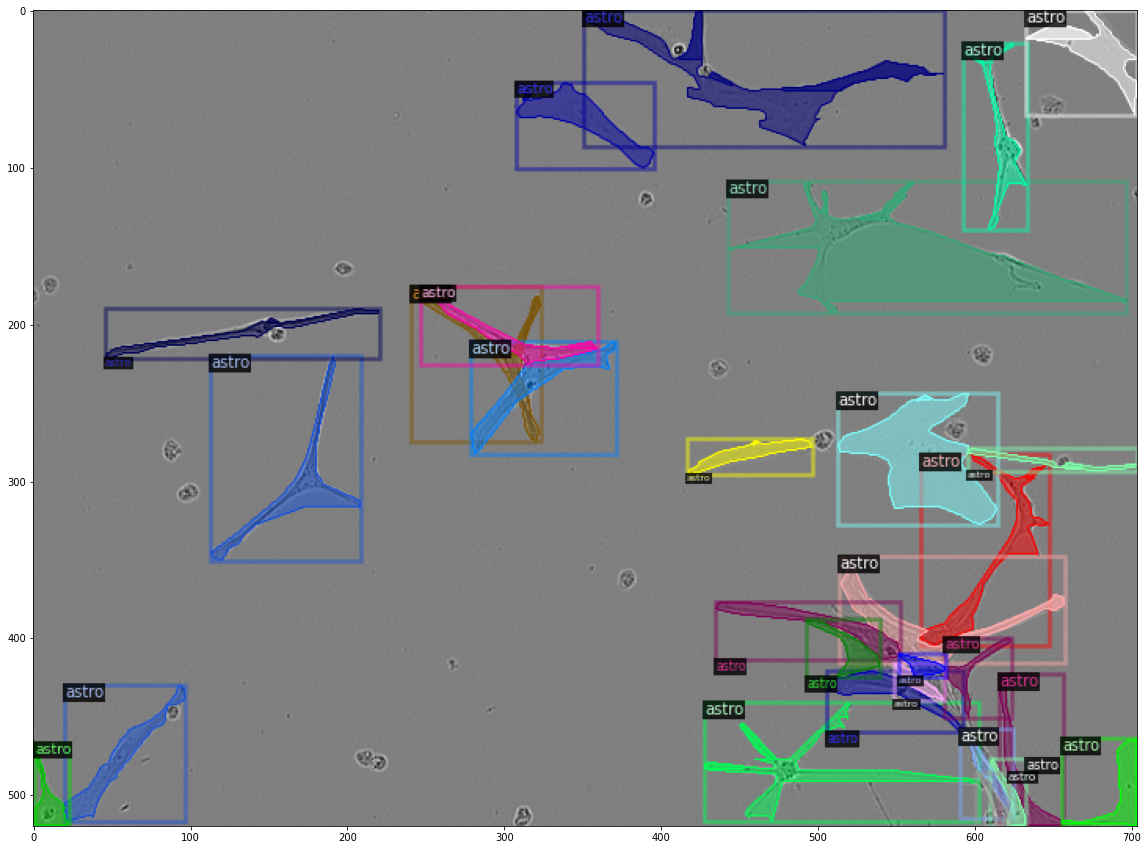

In [17]:
d = train_ds[42]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

# Define evaluator 
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311` 

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [18]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}    

# Efficientnet backbone

In [19]:
import math
import fvcore.nn.weight_init as weight_init
import torch
import torch.nn.functional as F
from torch import nn

from detectron2.modeling.backbone.build import BACKBONE_REGISTRY

In [20]:
from detectron2.modeling.backbone import Backbone

from detectron2.layers import (
    Conv2d,
    ShapeSpec,
    get_norm,
)

In [21]:
!pip install timm
import timm
from timm.models.efficientnet import *

     |████████████████████████████████| 376 kB 4.2 MB/s 


In [89]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train",)
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

# map 0.255 90 eps
#cfg.MODEL.WEIGHTS = "../input/retrain-of-efficientnetv2-hacked-detectron2/output/model_final.pth"

# Options: WarmupMultiStepLR, WarmupCosineLR.
# See detectron2/solver/build.py for definition.
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"

cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.IMS_PER_BATCH = 2

ITERATE_PER_EPOCH = len(DatasetCatalog.get('sartorius_train')) // cfg.SOLVER.IMS_PER_BATCH 

print("ITERATE_PER_EPOCH", ITERATE_PER_EPOCH)

cfg.SOLVER.BASE_LR = 5e-3
cfg.SOLVER.MAX_ITER = ITERATE_PER_EPOCH * 40
#cfg.SOLVER.STEPS = (ITERATE_PER_EPOCH * 10, ITERATE_PER_EPOCH * 15)      

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5

cfg.TEST.EVAL_PERIOD =  ITERATE_PER_EPOCH   # Once per epoch

# Enable automatic mixed precision for training
cfg.SOLVER.AMP.ENABLED = True


"""
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16], [32], [64], [128], [256], [512]]  # One size for each in feature map
cfg.MODEL.FPN.IN_FEATURES = ["b0", "b1", "b2", "b4", "b5"]

cfg.MODEL.RPN.IN_FEATURES =  ["p1", "p2", "p3", "p4", "p5", "p6"]
cfg.MODEL.ROI_HEADS.IN_FEATURES =  ["p1", "p2", "p3", "p4", "p5"]
"""

cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32], [64], [128], [256], [512]]  # One size for each in feature map
cfg.MODEL.FPN.IN_FEATURES = ["b1", "b2", "b4", "b5"]

cfg.MODEL.RPN.IN_FEATURES =  ["p2", "p3", "p4", "p5", "p6"]
cfg.MODEL.ROI_HEADS.IN_FEATURES =  ["p2", "p3", "p4", "p5"]
    
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

[12/13 12:17:57 d2.data.datasets.coco]: Loaded 484 images in COCO format from ./input/sartorius-kfold-coco/fold_json/fold_1_train.json
ITERATE_PER_EPOCH 242


In [23]:
class EfficientnetV2S(Backbone):
    def __init__(self):
        super().__init__()

        e = efficientnetv2_rw_s(pretrained=True, drop_path_rate=0.2)
        
        all_features = ["stem", "b0", "b1", "b2", "b3", "b4", "b5"] 
        out_features = ["b0", "b1", "b2", "b4", "b5"]
        # _stride = [2, 1, 2, 2, 2, 1, 2]
        self._out_feature_strides = {"stem": 2, "b0": 2, "b1": 4, "b2": 8, "b3": 16, "b4": 16, "b5": 32}
        #self._out_feature_channels = {"stem": 24, "b0": 24, "b1": 48, "b2": 64, "b3": 128, "b4": 160, "b5": 272}
        self._out_feature_channels = {"stem": 24, "b0": 64, "b1": 128, "b2": 256, "b3": 512, "b4": 1024, "b5": 1792}
        
        self.stem = nn.Sequential(
            e.conv_stem,
            e.bn1,
            e.act1,
        )
        
        self.b0 = e.blocks[0]
        self.b1 = e.blocks[1]
        self.b2 = e.blocks[2]
        self.b3 = e.blocks[3]
        self.b4 = e.blocks[4]
        self.b5 = e.blocks[5]
        
        # 12/07 add some conv head to feature mapping
        self.b0_conv = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=1, padding=0),
            nn.BatchNorm2d(64),
            nn.SiLU(inplace=True),
        )
        self.b1_conv = nn.Sequential(
            nn.Conv2d(48, 128, kernel_size=1, padding=0),
            nn.BatchNorm2d(128),
            nn.SiLU(inplace=True),
        )
        self.b2_conv = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=1, padding=0),
            nn.BatchNorm2d(256),
            nn.SiLU(inplace=True),
        )
        self.b3_conv = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=1, padding=0),
            nn.BatchNorm2d(512),
            nn.SiLU(inplace=True),
        )
        self.b4_conv = nn.Sequential(
            nn.Conv2d(160, 1024, kernel_size=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.SiLU(inplace=True),
        )
        self.b5_conv = nn.Sequential(
            e.conv_head,
            e.bn2,
            e.act2,
        )
        
        # shall B7 conv_head be used ? 

        self.stages = [e.blocks[n] for n in range(0, 6)]
        self.out_convs = [self.b0_conv, self.b1_conv, self.b2_conv, self.b3_conv, self.b4_conv, self.b5_conv]
        
        self.stage_names = all_features[1:]
        self._out_features = out_features


    def forward(self, x):
        """
        Args:
            x: Tensor of shape (N,C,H,W). H, W must be a multiple of ``self.size_divisibility``.

        Returns:
            dict[str->Tensor]: names and the corresponding features
        """
        assert x.dim() == 4, f"ResNet takes an input of shape (N, C, H, W). Got {x.shape} instead!"
        outputs = {}
        x = self.stem(x)
        if "stem" in self._out_features:
            outputs["stem"] = x
        for name, stage, out_conv in zip(self.stage_names, self.stages, self.out_convs):
            x = stage(x)
            if name in self._out_features:
                outputs[name] = out_conv(x)
        return outputs

    def output_shape(self):
        return {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }

In [24]:
del BACKBONE_REGISTRY._obj_map["build_resnet_backbone"] 
@BACKBONE_REGISTRY.register()
def build_resnet_backbone(cfg, input_shape):    
    return EfficientnetV2S()

## Sanity Test

In [25]:
input_shape = ShapeSpec(channels=3, height=None, width=None, stride=None)
bottom_up = build_resnet_backbone(cfg, input_shape)
print("_out_feature_channels", bottom_up._out_feature_channels)
print("_out_feature_strides", bottom_up._out_feature_strides)
print("output_shape", bottom_up.output_shape())

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_v2s_ra2_288-a6477665.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2s_ra2_288-a6477665.pth


_out_feature_channels {'stem': 24, 'b0': 64, 'b1': 128, 'b2': 256, 'b3': 512, 'b4': 1024, 'b5': 1792}
_out_feature_strides {'stem': 2, 'b0': 2, 'b1': 4, 'b2': 8, 'b3': 16, 'b4': 16, 'b5': 32}
output_shape {'b0': ShapeSpec(channels=64, height=None, width=None, stride=2), 'b1': ShapeSpec(channels=128, height=None, width=None, stride=4), 'b2': ShapeSpec(channels=256, height=None, width=None, stride=8), 'b4': ShapeSpec(channels=1024, height=None, width=None, stride=16), 'b5': ShapeSpec(channels=1792, height=None, width=None, stride=32)}


# FPN backbone

In [26]:
from detectron2.modeling.backbone.fpn import _assert_strides_are_log2_contiguous, LastLevelMaxPool

class FPN(Backbone):
    """
    This module implements :paper:`FPN`.
    It creates pyramid features built on top of some input feature maps.
    """

    _fuse_type: torch.jit.Final[str]

    def __init__(
        self, bottom_up, in_features, out_channels, norm="", top_block=None, fuse_type="sum"
    ):
        """
        Args:
            bottom_up (Backbone): module representing the bottom up subnetwork.
                Must be a subclass of :class:`Backbone`. The multi-scale feature
                maps generated by the bottom up network, and listed in `in_features`,
                are used to generate FPN levels.
            in_features (list[str]): names of the input feature maps coming
                from the backbone to which FPN is attached. For example, if the
                backbone produces ["res2", "res3", "res4"], any *contiguous* sublist
                of these may be used; order must be from high to low resolution.
            out_channels (int): number of channels in the output feature maps.
            norm (str): the normalization to use.
            top_block (nn.Module or None): if provided, an extra operation will
                be performed on the output of the last (smallest resolution)
                FPN output, and the result will extend the result list. The top_block
                further downsamples the feature map. It must have an attribute
                "num_levels", meaning the number of extra FPN levels added by
                this block, and "in_feature", which is a string representing
                its input feature (e.g., p5).
            fuse_type (str): types for fusing the top down features and the lateral
                ones. It can be "sum" (default), which sums up element-wise; or "avg",
                which takes the element-wise mean of the two.
        """
        super(FPN, self).__init__()
        assert isinstance(bottom_up, Backbone)
        assert in_features, in_features

        # Feature map strides and channels from the bottom up network (e.g. ResNet)
        input_shapes = bottom_up.output_shape()
        strides = [input_shapes[f].stride for f in in_features]
        in_channels_per_feature = [input_shapes[f].channels for f in in_features]
        
        _assert_strides_are_log2_contiguous(strides)
        lateral_convs = []
        output_convs = []

        use_bias = norm == ""
        for idx, in_channels in enumerate(in_channels_per_feature):
            lateral_norm = get_norm(norm, out_channels)
            output_norm = get_norm(norm, out_channels)

            lateral_conv = Conv2d(
                in_channels, out_channels, kernel_size=1, bias=use_bias, norm=lateral_norm
            )
            output_conv = Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=use_bias,
                norm=output_norm,
            )
            weight_init.c2_xavier_fill(lateral_conv)
            weight_init.c2_xavier_fill(output_conv)
            stage = int(math.log2(strides[idx]))
            self.add_module("fpn_lateral{}".format(stage), lateral_conv)
            self.add_module("fpn_output{}".format(stage), output_conv)

            lateral_convs.append(lateral_conv)
            output_convs.append(output_conv)
        # Place convs into top-down order (from low to high resolution)
        # to make the top-down computation in forward clearer.
        self.lateral_convs = lateral_convs[::-1]
        self.output_convs = output_convs[::-1]
        self.top_block = top_block
        self.in_features = tuple(in_features)
        self.bottom_up = bottom_up
        # Return feature names are "p<stage>", like ["p2", "p3", ..., "p6"]
        self._out_feature_strides = {"p{}".format(int(math.log2(s))): s for s in strides}
        # top block output feature maps.
        
        if self.top_block is not None:
            for s in range(stage, stage + self.top_block.num_levels):
                self._out_feature_strides["p{}".format(s + 1)] = 2 ** (s + 1)

        self._out_features = list(self._out_feature_strides.keys())
        self._out_feature_channels = {k: out_channels for k in self._out_features}
        self._size_divisibility = strides[-1]
        assert fuse_type in {"avg", "sum"}
        self._fuse_type = fuse_type

    @property
    def size_divisibility(self):
        return self._size_divisibility

    def forward(self, x):
        """
        Args:
            input (dict[str->Tensor]): mapping feature map name (e.g., "res5") to
                feature map tensor for each feature level in high to low resolution order.

        Returns:
            dict[str->Tensor]:
                mapping from feature map name to FPN feature map tensor
                in high to low resolution order. Returned feature names follow the FPN
                paper convention: "p<stage>", where stage has stride = 2 ** stage e.g.,
                ["p2", "p3", ..., "p6"].
        """
        bottom_up_features = self.bottom_up(x)
        results = []
        prev_features = self.lateral_convs[0](bottom_up_features[self.in_features[-1]])
        results.append(self.output_convs[0](prev_features))

        # Reverse feature maps into top-down order (from low to high resolution)
        for idx, (lateral_conv, output_conv) in enumerate(
            zip(self.lateral_convs, self.output_convs)
        ):
            # Slicing of ModuleList is not supported https://github.com/pytorch/pytorch/issues/47336
            # Therefore we loop over all modules but skip the first one
            if idx > 0:
                features = self.in_features[-idx - 1]
                features = bottom_up_features[features]
                top_down_features = F.interpolate(prev_features, scale_factor=2.0, mode="nearest")
                lateral_features = lateral_conv(features)
                prev_features = lateral_features + top_down_features
                if self._fuse_type == "avg":
                    prev_features /= 2
                results.insert(0, output_conv(prev_features))

        if self.top_block is not None:
            if self.top_block.in_feature in bottom_up_features:
                top_block_in_feature = bottom_up_features[self.top_block.in_feature]
            else:
                top_block_in_feature = results[self._out_features.index(self.top_block.in_feature)]
            results.extend(self.top_block(top_block_in_feature))
        assert len(self._out_features) == len(results)


        out = {f: res for f, res in zip(self._out_features, results)}
        # add a output with bottom_up_features last 

        out["b5_out"] = bottom_up_features["b5"]

        return out

    def output_shape(self):
        out = {
            name: ShapeSpec(
                channels=self._out_feature_channels[name], stride=self._out_feature_strides[name]
            )
            for name in self._out_features
        }
        out["b5_out"] = ShapeSpec(
                channels=1792, stride=32
            )
        return out

del BACKBONE_REGISTRY._obj_map["build_resnet_fpn_backbone"] 
@BACKBONE_REGISTRY.register()
def build_resnet_fpn_backbone(cfg, input_shape: ShapeSpec):

    """
    Args:
        cfg: a detectron2 CfgNode

    Returns:
        backbone (Backbone): backbone module, must be a subclass of :class:`Backbone`.
    """
    bottom_up = build_resnet_backbone(cfg, input_shape)
    in_features = cfg.MODEL.FPN.IN_FEATURES
    out_channels = cfg.MODEL.FPN.OUT_CHANNELS
    backbone = FPN(
        bottom_up=bottom_up,
        in_features=in_features,
        out_channels=out_channels,
        norm=cfg.MODEL.FPN.NORM,
        top_block=LastLevelMaxPool(),
        fuse_type=cfg.MODEL.FPN.FUSE_TYPE,
    )
    return backbone

## Sanity Check

In [27]:
bb = build_resnet_fpn_backbone(cfg, ShapeSpec(channels=3))
print(bb.output_shape())

{'p2': ShapeSpec(channels=256, height=None, width=None, stride=4), 'p3': ShapeSpec(channels=256, height=None, width=None, stride=8), 'p4': ShapeSpec(channels=256, height=None, width=None, stride=16), 'p5': ShapeSpec(channels=256, height=None, width=None, stride=32), 'p6': ShapeSpec(channels=256, height=None, width=None, stride=64), 'b5_out': ShapeSpec(channels=1792, height=None, width=None, stride=32)}


# Customize RPN and RPN head (region proposal)

## RPN

In [28]:
from detectron2.config import configurable
from detectron2.layers import cat
from detectron2.structures import Boxes, ImageList, Instances, pairwise_iou
from detectron2.utils.events import get_event_storage
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.utils.registry import Registry

from detectron2.modeling.anchor_generator import build_anchor_generator
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.matcher import Matcher
from detectron2.modeling.sampling import subsample_labels
from detectron2.modeling.proposal_generator.build import PROPOSAL_GENERATOR_REGISTRY
from detectron2.modeling.proposal_generator.proposal_utils import find_top_rpn_proposals


#from detectron2.modeling.proposal_generator.rpn import build_rpn_head


from typing import Dict, List, Optional, Tuple, Union
from fvcore.nn import giou_loss, smooth_l1_loss
from detectron2.layers import cat, ciou_loss, diou_loss

In [29]:
def _dense_box_regression_loss(
    anchors: List[Union[Boxes, torch.Tensor]],
    box2box_transform: Box2BoxTransform,
    pred_anchor_deltas: List[torch.Tensor],
    gt_boxes: List[torch.Tensor],
    fg_mask: torch.Tensor,
    box_reg_loss_type="smooth_l1",
    smooth_l1_beta=0.0,
):
    """
    Compute loss for dense multi-level box regression.
    Loss is accumulated over ``fg_mask``.

    Args:
        anchors: #lvl anchor boxes, each is (HixWixA, 4)
        pred_anchor_deltas: #lvl predictions, each is (N, HixWixA, 4)
        gt_boxes: N ground truth boxes, each has shape (R, 4) (R = sum(Hi * Wi * A))
        fg_mask: the foreground boolean mask of shape (N, R) to compute loss on
        box_reg_loss_type (str): Loss type to use. Supported losses: "smooth_l1", "giou",
            "diou", "ciou".
        smooth_l1_beta (float): beta parameter for the smooth L1 regression loss. Default to
            use L1 loss. Only used when `box_reg_loss_type` is "smooth_l1"
    """
    if isinstance(anchors[0], Boxes):
        anchors = type(anchors[0]).cat(anchors).tensor  # (R, 4)
    else:
        anchors = cat(anchors)
    if box_reg_loss_type == "smooth_l1":
        gt_anchor_deltas = [box2box_transform.get_deltas(anchors, k) for k in gt_boxes]
        gt_anchor_deltas = torch.stack(gt_anchor_deltas)  # (N, R, 4)
        loss_box_reg = smooth_l1_loss(
            cat(pred_anchor_deltas, dim=1)[fg_mask],
            gt_anchor_deltas[fg_mask],
            beta=smooth_l1_beta,
            reduction="sum",
        )
    elif box_reg_loss_type == "giou":
        pred_boxes = [
            box2box_transform.apply_deltas(k, anchors) for k in cat(pred_anchor_deltas, dim=1)
        ]
        loss_box_reg = giou_loss(
            torch.stack(pred_boxes)[fg_mask], torch.stack(gt_boxes)[fg_mask], reduction="sum"
        )
    elif box_reg_loss_type == "diou":
        pred_boxes = [
            box2box_transform.apply_deltas(k, anchors) for k in cat(pred_anchor_deltas, dim=1)
        ]
        loss_box_reg = diou_loss(
            torch.stack(pred_boxes)[fg_mask], torch.stack(gt_boxes)[fg_mask], reduction="sum"
        )
    elif box_reg_loss_type == "ciou":
        pred_boxes = [
            box2box_transform.apply_deltas(k, anchors) for k in cat(pred_anchor_deltas, dim=1)
        ]
        loss_box_reg = ciou_loss(
            torch.stack(pred_boxes)[fg_mask], torch.stack(gt_boxes)[fg_mask], reduction="sum"
        )
    else:
        raise ValueError(f"Invalid dense box regression loss type '{box_reg_loss_type}'")
    return loss_box_reg

In [30]:
RPN_HEAD_REGISTRY = Registry("RPN_HEAD")
#del RPN_HEAD_REGISTRY._obj_map["StandardRPNHead"]

@RPN_HEAD_REGISTRY.register()
class StandardRPNHead(nn.Module):
    """
    Standard RPN classification and regression heads described in :paper:`Faster R-CNN`.
    Uses a 3x3 conv to produce a shared hidden state from which one 1x1 conv predicts
    objectness logits for each anchor and a second 1x1 conv predicts bounding-box deltas
    specifying how to deform each anchor into an object proposal.
    """

    @configurable
    def __init__(
        self, *, in_channels: int, num_anchors: int, box_dim: int = 4, conv_dims: List[int] = (-1,)
    ):
        """
        NOTE: this interface is experimental.

        Args:
            in_channels (int): number of input feature channels. When using multiple
                input features, they must have the same number of channels.
            num_anchors (int): number of anchors to predict for *each spatial position*
                on the feature map. The total number of anchors for each
                feature map will be `num_anchors * H * W`.
            box_dim (int): dimension of a box, which is also the number of box regression
                predictions to make for each anchor. An axis aligned box has
                box_dim=4, while a rotated box has box_dim=5.
            conv_dims (list[int]): a list of integers representing the output channels
                of N conv layers. Set it to -1 to use the same number of output channels
                as input channels.
        """
        super().__init__()
        cur_channels = in_channels
        # Keeping the old variable names and structure for backwards compatiblity.
        # Otherwise the old checkpoints will fail to load.
        if len(conv_dims) == 1:
            out_channels = cur_channels if conv_dims[0] == -1 else conv_dims[0]
            # 3x3 conv for the hidden representation
            self.conv = self._get_rpn_conv(cur_channels, out_channels)
            cur_channels = out_channels
        else:
            self.conv = nn.Sequential()
            for k, conv_dim in enumerate(conv_dims):
                out_channels = cur_channels if conv_dim == -1 else conv_dim
                if out_channels <= 0:
                    raise ValueError(
                        f"Conv output channels should be greater than 0. Got {out_channels}"
                    )
                conv = self._get_rpn_conv(cur_channels, out_channels)
                self.conv.add_module(f"conv{k}", conv)
                cur_channels = out_channels
        # 1x1 conv for predicting objectness logits
        self.objectness_logits = nn.Conv2d(cur_channels, num_anchors, kernel_size=1, stride=1)
        # 1x1 conv for predicting box2box transform deltas
        self.anchor_deltas = nn.Conv2d(cur_channels, num_anchors * box_dim, kernel_size=1, stride=1)

        # Keeping the order of weights initialization same for backwards compatiblility.
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, std=0.01)
                nn.init.constant_(layer.bias, 0)

    def _get_rpn_conv(self, in_channels, out_channels):
        return Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            activation=nn.ReLU(),
        )

    @classmethod
    def from_config(cls, cfg, input_shape):
        # Standard RPN is shared across levels:
        in_channels = [s.channels for s in input_shape]
        assert len(set(in_channels)) == 1, "Each level must have the same channel!"
        in_channels = in_channels[0]

        # RPNHead should take the same input as anchor generator
        # NOTE: it assumes that creating an anchor generator does not have unwanted side effect.
        anchor_generator = build_anchor_generator(cfg, input_shape)
        num_anchors = anchor_generator.num_anchors
        box_dim = anchor_generator.box_dim
        assert (
            len(set(num_anchors)) == 1
        ), "Each level must have the same number of anchors per spatial position"
        return {
            "in_channels": in_channels,
            "num_anchors": num_anchors[0],
            "box_dim": box_dim,
            "conv_dims": cfg.MODEL.RPN.CONV_DIMS,
        }

    def forward(self, features: List[torch.Tensor]):
        """
        Args:
            features (list[Tensor]): list of feature maps

        Returns:
            list[Tensor]: A list of L elements.
                Element i is a tensor of shape (N, A, Hi, Wi) representing
                the predicted objectness logits for all anchors. A is the number of cell anchors.
            list[Tensor]: A list of L elements. Element i is a tensor of shape
                (N, A*box_dim, Hi, Wi) representing the predicted "deltas" used to transform anchors
                to proposals.
        """
        pred_objectness_logits = []
        pred_anchor_deltas = []
        for x in features:
            t = self.conv(x)
            pred_objectness_logits.append(self.objectness_logits(t))
            pred_anchor_deltas.append(self.anchor_deltas(t))
        #print("StandardRPNHead pred_objectness_logits", pred_objectness_logits.shape)
        return pred_objectness_logits, pred_anchor_deltas

In [31]:
del PROPOSAL_GENERATOR_REGISTRY._obj_map["RPN"]

@PROPOSAL_GENERATOR_REGISTRY.register()
class RPN(nn.Module):
    """
    Region Proposal Network, introduced by :paper:`Faster R-CNN`.
    """

    @configurable
    def __init__(
        self,
        *,
        in_features: List[str],
        head: nn.Module,
        anchor_generator: nn.Module,
        anchor_matcher: Matcher,
        box2box_transform: Box2BoxTransform,
        batch_size_per_image: int,
        positive_fraction: float,
        pre_nms_topk: Tuple[float, float],
        post_nms_topk: Tuple[float, float],
        nms_thresh: float = 0.7,
        min_box_size: float = 0.0,
        anchor_boundary_thresh: float = -1.0,
        loss_weight: Union[float, Dict[str, float]] = 1.0,
        box_reg_loss_type: str = "smooth_l1",
        smooth_l1_beta: float = 0.0,
    ):
        """
        NOTE: this interface is experimental.

        Args:
            in_features (list[str]): list of names of input features to use
            head (nn.Module): a module that predicts logits and regression deltas
                for each level from a list of per-level features
            anchor_generator (nn.Module): a module that creates anchors from a
                list of features. Usually an instance of :class:`AnchorGenerator`
            anchor_matcher (Matcher): label the anchors by matching them with ground truth.
            box2box_transform (Box2BoxTransform): defines the transform from anchors boxes to
                instance boxes
            batch_size_per_image (int): number of anchors per image to sample for training
            positive_fraction (float): fraction of foreground anchors to sample for training
            pre_nms_topk (tuple[float]): (train, test) that represents the
                number of top k proposals to select before NMS, in
                training and testing.
            post_nms_topk (tuple[float]): (train, test) that represents the
                number of top k proposals to select after NMS, in
                training and testing.
            nms_thresh (float): NMS threshold used to de-duplicate the predicted proposals
            min_box_size (float): remove proposal boxes with any side smaller than this threshold,
                in the unit of input image pixels
            anchor_boundary_thresh (float): legacy option
            loss_weight (float|dict): weights to use for losses. Can be single float for weighting
                all rpn losses together, or a dict of individual weightings. Valid dict keys are:
                    "loss_rpn_cls" - applied to classification loss
                    "loss_rpn_loc" - applied to box regression loss
            box_reg_loss_type (str): Loss type to use. Supported losses: "smooth_l1", "giou".
            smooth_l1_beta (float): beta parameter for the smooth L1 regression loss. Default to
                use L1 loss. Only used when `box_reg_loss_type` is "smooth_l1"
        """
        super().__init__()
        self.in_features = in_features
        self.rpn_head = head
        self.anchor_generator = anchor_generator
        self.anchor_matcher = anchor_matcher
        self.box2box_transform = box2box_transform
        self.batch_size_per_image = batch_size_per_image
        self.positive_fraction = positive_fraction
        # Map from self.training state to train/test settings
        self.pre_nms_topk = {True: pre_nms_topk[0], False: pre_nms_topk[1]}
        self.post_nms_topk = {True: post_nms_topk[0], False: post_nms_topk[1]}
        self.nms_thresh = nms_thresh
        self.min_box_size = float(min_box_size)
        self.anchor_boundary_thresh = anchor_boundary_thresh
        if isinstance(loss_weight, float):
            loss_weight = {"loss_rpn_cls": loss_weight, "loss_rpn_loc": loss_weight}
        self.loss_weight = loss_weight
        self.box_reg_loss_type = box_reg_loss_type
        self.smooth_l1_beta = smooth_l1_beta

    @classmethod
    def from_config(cls, cfg, input_shape: Dict[str, ShapeSpec]):
        in_features = cfg.MODEL.RPN.IN_FEATURES
        ret = {
            "in_features": in_features,
            "min_box_size": cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE,
            "nms_thresh": cfg.MODEL.RPN.NMS_THRESH,
            "batch_size_per_image": cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE,
            "positive_fraction": cfg.MODEL.RPN.POSITIVE_FRACTION,
            "loss_weight": {
                "loss_rpn_cls": cfg.MODEL.RPN.LOSS_WEIGHT,
                "loss_rpn_loc": cfg.MODEL.RPN.BBOX_REG_LOSS_WEIGHT * cfg.MODEL.RPN.LOSS_WEIGHT,
            },
            "anchor_boundary_thresh": cfg.MODEL.RPN.BOUNDARY_THRESH,
            "box2box_transform": Box2BoxTransform(weights=cfg.MODEL.RPN.BBOX_REG_WEIGHTS),
            "box_reg_loss_type": cfg.MODEL.RPN.BBOX_REG_LOSS_TYPE,
            "smooth_l1_beta": cfg.MODEL.RPN.SMOOTH_L1_BETA,
        }

        ret["pre_nms_topk"] = (cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN, cfg.MODEL.RPN.PRE_NMS_TOPK_TEST)
        ret["post_nms_topk"] = (cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN, cfg.MODEL.RPN.POST_NMS_TOPK_TEST)

        ret["anchor_generator"] = build_anchor_generator(cfg, [input_shape[f] for f in in_features])
        ret["anchor_matcher"] = Matcher(
            cfg.MODEL.RPN.IOU_THRESHOLDS, cfg.MODEL.RPN.IOU_LABELS, allow_low_quality_matches=True
        )
        ret["head"] = build_rpn_head(cfg, [input_shape[f] for f in in_features])
        return ret

    def _subsample_labels(self, label):
        """
        Randomly sample a subset of positive and negative examples, and overwrite
        the label vector to the ignore value (-1) for all elements that are not
        included in the sample.

        Args:
            labels (Tensor): a vector of -1, 0, 1. Will be modified in-place and returned.
        """
        pos_idx, neg_idx = subsample_labels(
            label, self.batch_size_per_image, self.positive_fraction, 0
        )
        # Fill with the ignore label (-1), then set positive and negative labels
        label.fill_(-1)
        label.scatter_(0, pos_idx, 1)
        label.scatter_(0, neg_idx, 0)
        return label

    @torch.jit.unused
    @torch.no_grad()
    def label_and_sample_anchors(
        self, anchors: List[Boxes], gt_instances: List[Instances]
    ) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        """
        Args:
            anchors (list[Boxes]): anchors for each feature map.
            gt_instances: the ground-truth instances for each image.

        Returns:
            list[Tensor]:
                List of #img tensors. i-th element is a vector of labels whose length is
                the total number of anchors across all feature maps R = sum(Hi * Wi * A).
                Label values are in {-1, 0, 1}, with meanings: -1 = ignore; 0 = negative
                class; 1 = positive class.
            list[Tensor]:
                i-th element is a Rx4 tensor. The values are the matched gt boxes for each
                anchor. Values are undefined for those anchors not labeled as 1.
        """
        anchors = Boxes.cat(anchors)

        gt_boxes = [x.gt_boxes for x in gt_instances]
        image_sizes = [x.image_size for x in gt_instances]
        del gt_instances

        gt_labels = []
        matched_gt_boxes = []
        for image_size_i, gt_boxes_i in zip(image_sizes, gt_boxes):
            """
            image_size_i: (h, w) for the i-th image
            gt_boxes_i: ground-truth boxes for i-th image
            """

            match_quality_matrix = retry_if_cuda_oom(pairwise_iou)(gt_boxes_i, anchors)
            matched_idxs, gt_labels_i = retry_if_cuda_oom(self.anchor_matcher)(match_quality_matrix)
            # Matching is memory-expensive and may result in CPU tensors. But the result is small
            gt_labels_i = gt_labels_i.to(device=gt_boxes_i.device)
            del match_quality_matrix

            if self.anchor_boundary_thresh >= 0:
                # Discard anchors that go out of the boundaries of the image
                # NOTE: This is legacy functionality that is turned off by default in Detectron2
                anchors_inside_image = anchors.inside_box(image_size_i, self.anchor_boundary_thresh)
                gt_labels_i[~anchors_inside_image] = -1

            # A vector of labels (-1, 0, 1) for each anchor
            gt_labels_i = self._subsample_labels(gt_labels_i)

            if len(gt_boxes_i) == 0:
                # These values won't be used anyway since the anchor is labeled as background
                matched_gt_boxes_i = torch.zeros_like(anchors.tensor)
            else:
                # TODO wasted indexing computation for ignored boxes
                matched_gt_boxes_i = gt_boxes_i[matched_idxs].tensor

            gt_labels.append(gt_labels_i)  # N,AHW
            matched_gt_boxes.append(matched_gt_boxes_i)
        return gt_labels, matched_gt_boxes

    @torch.jit.unused
    def losses(
        self,
        anchors: List[Boxes],
        pred_objectness_logits: List[torch.Tensor],
        gt_labels: List[torch.Tensor],
        pred_anchor_deltas: List[torch.Tensor],
        gt_boxes: List[torch.Tensor],
    ) -> Dict[str, torch.Tensor]:
        """
        Return the losses from a set of RPN predictions and their associated ground-truth.

        Args:
            anchors (list[Boxes or RotatedBoxes]): anchors for each feature map, each
                has shape (Hi*Wi*A, B), where B is box dimension (4 or 5).
            pred_objectness_logits (list[Tensor]): A list of L elements.
                Element i is a tensor of shape (N, Hi*Wi*A) representing
                the predicted objectness logits for all anchors.
            gt_labels (list[Tensor]): Output of :meth:`label_and_sample_anchors`.
            pred_anchor_deltas (list[Tensor]): A list of L elements. Element i is a tensor of shape
                (N, Hi*Wi*A, 4 or 5) representing the predicted "deltas" used to transform anchors
                to proposals.
            gt_boxes (list[Tensor]): Output of :meth:`label_and_sample_anchors`.

        Returns:
            dict[loss name -> loss value]: A dict mapping from loss name to loss value.
                Loss names are: `loss_rpn_cls` for objectness classification and
                `loss_rpn_loc` for proposal localization.
        """
        num_images = len(gt_labels)
        gt_labels = torch.stack(gt_labels)  # (N, sum(Hi*Wi*Ai))

        # Log the number of positive/negative anchors per-image that's used in training
        pos_mask = gt_labels == 1
        num_pos_anchors = pos_mask.sum().item()
        num_neg_anchors = (gt_labels == 0).sum().item()
        storage = get_event_storage()
        storage.put_scalar("rpn/num_pos_anchors", num_pos_anchors / num_images)
        storage.put_scalar("rpn/num_neg_anchors", num_neg_anchors / num_images)

        localization_loss = _dense_box_regression_loss(
            anchors,
            self.box2box_transform,
            pred_anchor_deltas,
            gt_boxes,
            pos_mask,
            box_reg_loss_type=self.box_reg_loss_type,
            smooth_l1_beta=self.smooth_l1_beta,
        )

        valid_mask = gt_labels >= 0
        objectness_loss = F.binary_cross_entropy_with_logits(
            cat(pred_objectness_logits, dim=1)[valid_mask],
            gt_labels[valid_mask].to(torch.float32),
            reduction="sum",
        )
        normalizer = self.batch_size_per_image * num_images
        losses = {
            "loss_rpn_cls": objectness_loss / normalizer,
            # The original Faster R-CNN paper uses a slightly different normalizer
            # for loc loss. But it doesn't matter in practice
            "loss_rpn_loc": localization_loss / normalizer,
        }
        losses = {k: v * self.loss_weight.get(k, 1.0) for k, v in losses.items()}
        return losses

    def forward(
        self,
        images: ImageList,
        features: Dict[str, torch.Tensor],
        gt_instances: Optional[List[Instances]] = None,
    ):
        """
        Args:
            images (ImageList): input images of length `N`
            features (dict[str, Tensor]): input data as a mapping from feature
                map name to tensor. Axis 0 represents the number of images `N` in
                the input data; axes 1-3 are channels, height, and width, which may
                vary between feature maps (e.g., if a feature pyramid is used).
            gt_instances (list[Instances], optional): a length `N` list of `Instances`s.
                Each `Instances` stores ground-truth instances for the corresponding image.

        Returns:
            proposals: list[Instances]: contains fields "proposal_boxes", "objectness_logits"
            loss: dict[Tensor] or None
        """
        features = [features[f] for f in self.in_features]
        anchors = self.anchor_generator(features)

        pred_objectness_logits, pred_anchor_deltas = self.rpn_head(features)
        # Transpose the Hi*Wi*A dimension to the middle:
        pred_objectness_logits = [
            # (N, A, Hi, Wi) -> (N, Hi, Wi, A) -> (N, Hi*Wi*A)
            score.permute(0, 2, 3, 1).flatten(1)
            for score in pred_objectness_logits
        ]
        pred_anchor_deltas = [
            # (N, A*B, Hi, Wi) -> (N, A, B, Hi, Wi) -> (N, Hi, Wi, A, B) -> (N, Hi*Wi*A, B)
            x.view(x.shape[0], -1, self.anchor_generator.box_dim, x.shape[-2], x.shape[-1])
            .permute(0, 3, 4, 1, 2)
            .flatten(1, -2)
            for x in pred_anchor_deltas
        ]

        if self.training:
            assert gt_instances is not None, "RPN requires gt_instances in training!"
            gt_labels, gt_boxes = self.label_and_sample_anchors(anchors, gt_instances)
            losses = self.losses(
                anchors, pred_objectness_logits, gt_labels, pred_anchor_deltas, gt_boxes
            )
        else:
            losses = {}
        proposals = self.predict_proposals(
            anchors, pred_objectness_logits, pred_anchor_deltas, images.image_sizes
        )
        #print("RPN loss", losses)
        return proposals, losses

    def predict_proposals(
        self,
        anchors: List[Boxes],
        pred_objectness_logits: List[torch.Tensor],
        pred_anchor_deltas: List[torch.Tensor],
        image_sizes: List[Tuple[int, int]],
    ):
        """
        Decode all the predicted box regression deltas to proposals. Find the top proposals
        by applying NMS and removing boxes that are too small.

        Returns:
            proposals (list[Instances]): list of N Instances. The i-th Instances
                stores post_nms_topk object proposals for image i, sorted by their
                objectness score in descending order.
        """
        # The proposals are treated as fixed for joint training with roi heads.
        # This approach ignores the derivative w.r.t. the proposal boxes’ coordinates that
        # are also network responses.
        with torch.no_grad():
            pred_proposals = self._decode_proposals(anchors, pred_anchor_deltas)
            return find_top_rpn_proposals(
                pred_proposals,
                pred_objectness_logits,
                image_sizes,
                self.nms_thresh,
                self.pre_nms_topk[self.training],
                self.post_nms_topk[self.training],
                self.min_box_size,
                self.training,
            )

    def _decode_proposals(self, anchors: List[Boxes], pred_anchor_deltas: List[torch.Tensor]):
        """
        Transform anchors into proposals by applying the predicted anchor deltas.

        Returns:
            proposals (list[Tensor]): A list of L tensors. Tensor i has shape
                (N, Hi*Wi*A, B)
        """
        N = pred_anchor_deltas[0].shape[0]
        proposals = []
        # For each feature map
        for anchors_i, pred_anchor_deltas_i in zip(anchors, pred_anchor_deltas):
            B = anchors_i.tensor.size(1)
            pred_anchor_deltas_i = pred_anchor_deltas_i.reshape(-1, B)
            # Expand anchors to shape (N*Hi*Wi*A, B)
            anchors_i = anchors_i.tensor.unsqueeze(0).expand(N, -1, -1).reshape(-1, B)
            proposals_i = self.box2box_transform.apply_deltas(pred_anchor_deltas_i, anchors_i)
            # Append feature map proposals with shape (N, Hi*Wi*A, B)
            proposals.append(proposals_i.view(N, -1, B))
        return proposals

## Region proposal Test

In [32]:
def build_rpn_head(cfg, input_shape):
    """
    Build an RPN head defined by `cfg.MODEL.RPN.HEAD_NAME`.
    """
    name = cfg.MODEL.RPN.HEAD_NAME
    return RPN_HEAD_REGISTRY.get(name)(cfg, input_shape)

In [33]:
from detectron2.modeling.proposal_generator import build_proposal_generator

In [34]:
rpn = build_proposal_generator(cfg, bb.output_shape())
print(rpn)

RPN(
  (rpn_head): StandardRPNHead(
    (conv): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (activation): ReLU()
    )
    (objectness_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (anchor_deltas): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
  (anchor_generator): DefaultAnchorGenerator(
    (cell_anchors): BufferList()
  )
)


# Customize ROI head (box reg head mask head)

## standard Roi head

In [35]:
from detectron2.modeling.roi_heads import ROIHeads
from detectron2.modeling.poolers import ROIPooler

In [36]:
import inspect
from detectron2.modeling.roi_heads import select_foreground_proposals

ROI_HEADS_REGISTRY = Registry("ROI_HEADS")

@ROI_HEADS_REGISTRY.register()
class StandardROIHeads(ROIHeads):
    """
    It's "standard" in a sense that there is no ROI transform sharing
    or feature sharing between tasks.
    Each head independently processes the input features by each head's
    own pooler and head.

    This class is used by most models, such as FPN and C5.
    To implement more models, you can subclass it and implement a different
    :meth:`forward()` or a head.
    """

    @configurable
    def __init__(
        self,
        *,
        box_in_features: List[str],
        box_pooler: ROIPooler,
        box_head: nn.Module,
        box_predictor: nn.Module,
        mask_in_features: Optional[List[str]] = None,
        mask_pooler: Optional[ROIPooler] = None,
        mask_head: Optional[nn.Module] = None,
        keypoint_in_features: Optional[List[str]] = None,
        keypoint_pooler: Optional[ROIPooler] = None,
        keypoint_head: Optional[nn.Module] = None,
        train_on_pred_boxes: bool = False,
        **kwargs,
    ):
        """
        NOTE: this interface is experimental.

        Args:
            box_in_features (list[str]): list of feature names to use for the box head.
            box_pooler (ROIPooler): pooler to extra region features for box head
            box_head (nn.Module): transform features to make box predictions
            box_predictor (nn.Module): make box predictions from the feature.
                Should have the same interface as :class:`FastRCNNOutputLayers`.
            mask_in_features (list[str]): list of feature names to use for the mask
                pooler or mask head. None if not using mask head.
            mask_pooler (ROIPooler): pooler to extract region features from image features.
                The mask head will then take region features to make predictions.
                If None, the mask head will directly take the dict of image features
                defined by `mask_in_features`
            mask_head (nn.Module): transform features to make mask predictions
            keypoint_in_features, keypoint_pooler, keypoint_head: similar to ``mask_*``.
            train_on_pred_boxes (bool): whether to use proposal boxes or
                predicted boxes from the box head to train other heads.
        """
        super().__init__(**kwargs)
        # keep self.in_features for backward compatibility
        self.in_features = self.box_in_features = box_in_features
        self.box_pooler = box_pooler
        self.box_head = box_head
        self.box_predictor = box_predictor

        self.mask_on = mask_in_features is not None
        if self.mask_on:
            self.mask_in_features = mask_in_features
            self.mask_pooler = mask_pooler
            self.mask_head = mask_head

        #self.keypoint_on = keypoint_in_features is not None
        #if self.keypoint_on:
        #    self.keypoint_in_features = keypoint_in_features
        #    self.keypoint_pooler = keypoint_pooler
        #    self.keypoint_head = keypoint_head

        self.train_on_pred_boxes = train_on_pred_boxes

    @classmethod
    def from_config(cls, cfg, input_shape):
        ret = super().from_config(cfg)
        ret["train_on_pred_boxes"] = cfg.MODEL.ROI_BOX_HEAD.TRAIN_ON_PRED_BOXES
        # Subclasses that have not been updated to use from_config style construction
        # may have overridden _init_*_head methods. In this case, those overridden methods
        # will not be classmethods and we need to avoid trying to call them here.
        # We test for this with ismethod which only returns True for bound methods of cls.
        # Such subclasses will need to handle calling their overridden _init_*_head methods.
        if inspect.ismethod(cls._init_box_head):
            ret.update(cls._init_box_head(cfg, input_shape))
        if inspect.ismethod(cls._init_mask_head):
            ret.update(cls._init_mask_head(cfg, input_shape))
        #if inspect.ismethod(cls._init_keypoint_head):
        #    ret.update(cls._init_keypoint_head(cfg, input_shape))
        return ret

    @classmethod
    def _init_box_head(cls, cfg, input_shape):
        # fmt: off
        in_features       = cfg.MODEL.ROI_HEADS.IN_FEATURES
        pooler_resolution = cfg.MODEL.ROI_BOX_HEAD.POOLER_RESOLUTION
        pooler_scales     = tuple(1.0 / input_shape[k].stride for k in in_features)
        sampling_ratio    = cfg.MODEL.ROI_BOX_HEAD.POOLER_SAMPLING_RATIO
        pooler_type       = cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE
        # fmt: on

        # If StandardROIHeads is applied on multiple feature maps (as in FPN),
        # then we share the same predictors and therefore the channel counts must be the same
        in_channels = [input_shape[f].channels for f in in_features]
        # Check all channel counts are equal
        assert len(set(in_channels)) == 1, in_channels
        in_channels = in_channels[0]

        box_pooler = ROIPooler(
            output_size=pooler_resolution,
            scales=pooler_scales,
            sampling_ratio=sampling_ratio,
            pooler_type=pooler_type,
        )
        # Here we split "box head" and "box predictor", which is mainly due to historical reasons.
        # They are used together so the "box predictor" layers should be part of the "box head".
        # New subclasses of ROIHeads do not need "box predictor"s.
        box_head = build_box_head(
            cfg, ShapeSpec(channels=in_channels, height=pooler_resolution, width=pooler_resolution)
        )
        box_predictor = FastRCNNOutputLayers(cfg, box_head.output_shape)
        return {
            "box_in_features": in_features,
            "box_pooler": box_pooler,
            "box_head": box_head,
            "box_predictor": box_predictor,
        }

    @classmethod
    def _init_mask_head(cls, cfg, input_shape):
        if not cfg.MODEL.MASK_ON:
            return {}
        # fmt: off
        in_features       = cfg.MODEL.ROI_HEADS.IN_FEATURES
        pooler_resolution = cfg.MODEL.ROI_MASK_HEAD.POOLER_RESOLUTION
        pooler_scales     = tuple(1.0 / input_shape[k].stride for k in in_features)
        sampling_ratio    = cfg.MODEL.ROI_MASK_HEAD.POOLER_SAMPLING_RATIO
        pooler_type       = cfg.MODEL.ROI_MASK_HEAD.POOLER_TYPE
        # fmt: on

        in_channels = [input_shape[f].channels for f in in_features][0]

        ret = {"mask_in_features": in_features}
        ret["mask_pooler"] = (
            ROIPooler(
                output_size=pooler_resolution,
                scales=pooler_scales,
                sampling_ratio=sampling_ratio,
                pooler_type=pooler_type,
            )
            if pooler_type
            else None
        )
        if pooler_type:
            shape = ShapeSpec(
                channels=in_channels, width=pooler_resolution, height=pooler_resolution
            )
        else:
            shape = {f: input_shape[f] for f in in_features}
        ret["mask_head"] = build_mask_head(cfg, shape)
        return ret  

    def forward(
        self,
        images: ImageList,
        features: Dict[str, torch.Tensor],
        proposals: List[Instances],
        targets: Optional[List[Instances]] = None,
    ) -> Tuple[List[Instances], Dict[str, torch.Tensor]]:
        """
        See :class:`ROIHeads.forward`.
        """
        del images
        if self.training:
            assert targets, "'targets' argument is required during training"
            proposals = self.label_and_sample_proposals(proposals, targets)
        del targets

        if self.training:
            losses = self._forward_box(features, proposals)
            # Usually the original proposals used by the box head are used by the mask, keypoint
            # heads. But when `self.train_on_pred_boxes is True`, proposals will contain boxes
            # predicted by the box head.
            losses.update(self._forward_mask(features, proposals))
            #losses.update(self._forward_keypoint(features, proposals))
            #print("roi head losses", losses)
            return proposals, losses
        else:
            pred_instances = self._forward_box(features, proposals)
            # During inference cascaded prediction is used: the mask and keypoints heads are only
            # applied to the top scoring box detections.
            pred_instances = self.forward_with_given_boxes(features, pred_instances)
            return pred_instances, {}

    def forward_with_given_boxes(
        self, features: Dict[str, torch.Tensor], instances: List[Instances]
    ) -> List[Instances]:
        """
        Use the given boxes in `instances` to produce other (non-box) per-ROI outputs.

        This is useful for downstream tasks where a box is known, but need to obtain
        other attributes (outputs of other heads).
        Test-time augmentation also uses this.

        Args:
            features: same as in `forward()`
            instances (list[Instances]): instances to predict other outputs. Expect the keys
                "pred_boxes" and "pred_classes" to exist.

        Returns:
            list[Instances]:
                the same `Instances` objects, with extra
                fields such as `pred_masks` or `pred_keypoints`.
        """
        assert not self.training
        assert instances[0].has("pred_boxes") and instances[0].has("pred_classes")

        instances = self._forward_mask(features, instances)
        #instances = self._forward_keypoint(features, instances)
        return instances

    def _forward_box(self, features: Dict[str, torch.Tensor], proposals: List[Instances]):
        """
        Forward logic of the box prediction branch. If `self.train_on_pred_boxes is True`,
            the function puts predicted boxes in the `proposal_boxes` field of `proposals` argument.

        Args:
            features (dict[str, Tensor]): mapping from feature map names to tensor.
                Same as in :meth:`ROIHeads.forward`.
            proposals (list[Instances]): the per-image object proposals with
                their matching ground truth.
                Each has fields "proposal_boxes", and "objectness_logits",
                "gt_classes", "gt_boxes".

        Returns:
            In training, a dict of losses.
            In inference, a list of `Instances`, the predicted instances.
        """
        features = [features[f] for f in self.box_in_features]
        box_features = self.box_pooler(features, [x.proposal_boxes for x in proposals])
        box_features = self.box_head(box_features)
        predictions = self.box_predictor(box_features)
        del box_features

        if self.training:
            losses = self.box_predictor.losses(predictions, proposals)
            # proposals is modified in-place below, so losses must be computed first.
            if self.train_on_pred_boxes:
                with torch.no_grad():
                    pred_boxes = self.box_predictor.predict_boxes_for_gt_classes(
                        predictions, proposals
                    )
                    for proposals_per_image, pred_boxes_per_image in zip(proposals, pred_boxes):
                        proposals_per_image.proposal_boxes = Boxes(pred_boxes_per_image)
            return losses
        else:
            pred_instances, _ = self.box_predictor.inference(predictions, proposals)
            return pred_instances

    def _forward_mask(self, features: Dict[str, torch.Tensor], instances: List[Instances]):
        """
        Forward logic of the mask prediction branch.

        Args:
            features (dict[str, Tensor]): mapping from feature map names to tensor.
                Same as in :meth:`ROIHeads.forward`.
            instances (list[Instances]): the per-image instances to train/predict masks.
                In training, they can be the proposals.
                In inference, they can be the boxes predicted by R-CNN box head.

        Returns:
            In training, a dict of losses.
            In inference, update `instances` with new fields "pred_masks" and return it.
        """
        if not self.mask_on:
            return {} if self.training else instances

        if self.training:
            # head is only trained on positive proposals.
            instances, _ = select_foreground_proposals(instances, self.num_classes)

        if self.mask_pooler is not None:
            features = [features[f] for f in self.mask_in_features]
            boxes = [x.proposal_boxes if self.training else x.pred_boxes for x in instances]
            features = self.mask_pooler(features, boxes)
        else:
            features = {f: features[f] for f in self.mask_in_features}
        return self.mask_head(features, instances)

    

## FastRCNNOutputLayers

In [83]:
from detectron2.modeling.roi_heads.fast_rcnn import _log_classification_stats, fast_rcnn_inference
from detectron2.layers import cross_entropy, nonzero_tuple

class FastRCNNOutputLayers(nn.Module):
    """
    Two linear layers for predicting Fast R-CNN outputs:

    1. proposal-to-detection box regression deltas
    2. classification scores
    """

    @configurable
    def __init__(
        self,
        input_shape: ShapeSpec,
        *,
        box2box_transform,
        num_classes: int,
        test_score_thresh: float = 0.0,
        test_nms_thresh: float = 0.5,
        test_topk_per_image: int = 100,
        cls_agnostic_bbox_reg: bool = False,
        smooth_l1_beta: float = 0.0,
        box_reg_loss_type: str = "smooth_l1",
        loss_weight: Union[float, Dict[str, float]] = 1.0,
    ):
        """
        NOTE: this interface is experimental.

        Args:
            input_shape (ShapeSpec): shape of the input feature to this module
            box2box_transform (Box2BoxTransform or Box2BoxTransformRotated):
            num_classes (int): number of foreground classes
            test_score_thresh (float): threshold to filter predictions results.
            test_nms_thresh (float): NMS threshold for prediction results.
            test_topk_per_image (int): number of top predictions to produce per image.
            cls_agnostic_bbox_reg (bool): whether to use class agnostic for bbox regression
            smooth_l1_beta (float): transition point from L1 to L2 loss. Only used if
                `box_reg_loss_type` is "smooth_l1"
            box_reg_loss_type (str): Box regression loss type. One of: "smooth_l1", "giou",
                "diou", "ciou"
            loss_weight (float|dict): weights to use for losses. Can be single float for weighting
                all losses, or a dict of individual weightings. Valid dict keys are:
                    * "loss_cls": applied to classification loss
                    * "loss_box_reg": applied to box regression loss
        """
        super().__init__()
        if isinstance(input_shape, int):  # some backward compatibility
            input_shape = ShapeSpec(channels=input_shape)
        self.num_classes = num_classes
        input_size = input_shape.channels * (input_shape.width or 1) * (input_shape.height or 1)
        # prediction layer for num_classes foreground classes and one background class (hence + 1)
        self.cls_score = nn.Linear(input_size, num_classes + 1)
        num_bbox_reg_classes = 1 if cls_agnostic_bbox_reg else num_classes
        box_dim = len(box2box_transform.weights)
        self.bbox_pred = nn.Linear(input_size, num_bbox_reg_classes * box_dim)

        nn.init.normal_(self.cls_score.weight, std=0.01)
        nn.init.normal_(self.bbox_pred.weight, std=0.001)
        for l in [self.cls_score, self.bbox_pred]:
            nn.init.constant_(l.bias, 0)

        self.box2box_transform = box2box_transform
        self.smooth_l1_beta = smooth_l1_beta
        self.test_score_thresh = test_score_thresh
        self.test_nms_thresh = test_nms_thresh
        self.test_topk_per_image = test_topk_per_image
        self.box_reg_loss_type = box_reg_loss_type
        if isinstance(loss_weight, float):
            loss_weight = {"loss_cls": loss_weight, "loss_box_reg": loss_weight}
        self.loss_weight = loss_weight

    @classmethod
    def from_config(cls, cfg, input_shape):
        return {
            "input_shape": input_shape,
            "box2box_transform": Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS),
            # fmt: off
            "num_classes"           : cfg.MODEL.ROI_HEADS.NUM_CLASSES,
            "cls_agnostic_bbox_reg" : cfg.MODEL.ROI_BOX_HEAD.CLS_AGNOSTIC_BBOX_REG,
            "smooth_l1_beta"        : cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA,
            "test_score_thresh"     : cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST,
            "test_nms_thresh"       : cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST,
            "test_topk_per_image"   : cfg.TEST.DETECTIONS_PER_IMAGE,
            "box_reg_loss_type"     : cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_TYPE,
            "loss_weight"           : {"loss_box_reg": cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_LOSS_WEIGHT},
            # fmt: on
        }

    def forward(self, x):
        """
        Args:
            x: per-region features of shape (N, ...) for N bounding boxes to predict.

        Returns:
            (Tensor, Tensor):
            First tensor: shape (N,K+1), scores for each of the N box. Each row contains the
            scores for K object categories and 1 background class.

            Second tensor: bounding box regression deltas for each box. Shape is shape (N,Kx4),
            or (N,4) for class-agnostic regression.
        """
        if x.dim() > 2:
            x = torch.flatten(x, start_dim=1)
        scores = self.cls_score(x)
        proposal_deltas = self.bbox_pred(x)
        #print("FastRCNNOutputLayers scores", scores.shape)
        return scores, proposal_deltas

    def losses(self, predictions, proposals):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were used
                to compute predictions. The fields ``proposal_boxes``, ``gt_boxes``,
                ``gt_classes`` are expected.

        Returns:
            Dict[str, Tensor]: dict of losses
        """
        scores, proposal_deltas = predictions

        # parse classification outputs
        gt_classes = (
            cat([p.gt_classes for p in proposals], dim=0) if len(proposals) else torch.empty(0)
        )
        _log_classification_stats(scores, gt_classes)

        # parse box regression outputs
        if len(proposals):
            proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)  # Nx4
            assert not proposal_boxes.requires_grad, "Proposals should not require gradients!"
            # If "gt_boxes" does not exist, the proposals must be all negative and
            # should not be included in regression loss computation.
            # Here we just use proposal_boxes as an arbitrary placeholder because its
            # value won't be used in self.box_reg_loss().
            gt_boxes = cat(
                [(p.gt_boxes if p.has("gt_boxes") else p.proposal_boxes).tensor for p in proposals],
                dim=0,
            )
        else:
            proposal_boxes = gt_boxes = torch.empty((0, 4), device=proposal_deltas.device)

        losses = {
            "loss_cls": cross_entropy(scores, gt_classes, reduction="mean"),
            "loss_box_reg": self.box_reg_loss(
                proposal_boxes, gt_boxes, proposal_deltas, gt_classes
            ),
        }
        return {k: v * self.loss_weight.get(k, 1.0) for k, v in losses.items()}

    def box_reg_loss(self, proposal_boxes, gt_boxes, pred_deltas, gt_classes):
        """
        Args:
            proposal_boxes/gt_boxes are tensors with the same shape (R, 4 or 5).
            pred_deltas has shape (R, 4 or 5), or (R, num_classes * (4 or 5)).
            gt_classes is a long tensor of shape R, the gt class label of each proposal.
            R shall be the number of proposals.
        """
        box_dim = proposal_boxes.shape[1]  # 4 or 5
        # Regression loss is only computed for foreground proposals (those matched to a GT)
        fg_inds = nonzero_tuple((gt_classes >= 0) & (gt_classes < self.num_classes))[0]
        if pred_deltas.shape[1] == box_dim:  # cls-agnostic regression
            fg_pred_deltas = pred_deltas[fg_inds]
        else:
            fg_pred_deltas = pred_deltas.view(-1, self.num_classes, box_dim)[
                fg_inds, gt_classes[fg_inds]
            ]

        loss_box_reg = _dense_box_regression_loss(
            [proposal_boxes[fg_inds]],
            self.box2box_transform,
            [fg_pred_deltas.unsqueeze(0)],
            [gt_boxes[fg_inds]],
            ...,
            self.box_reg_loss_type,
            self.smooth_l1_beta,
        )

        # The reg loss is normalized using the total number of regions (R), not the number
        # of foreground regions even though the box regression loss is only defined on
        # foreground regions. Why? Because doing so gives equal training influence to
        # each foreground example. To see how, consider two different minibatches:
        #  (1) Contains a single foreground region
        #  (2) Contains 100 foreground regions
        # If we normalize by the number of foreground regions, the single example in
        # minibatch (1) will be given 100 times as much influence as each foreground
        # example in minibatch (2). Normalizing by the total number of regions, R,
        # means that the single example in minibatch (1) and each of the 100 examples
        # in minibatch (2) are given equal influence.
        return loss_box_reg / max(gt_classes.numel(), 1.0)  # return 0 if empty

    def inference(self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions. The ``proposal_boxes`` field is expected.

        Returns:
            list[Instances]: same as `fast_rcnn_inference`.
            list[Tensor]: same as `fast_rcnn_inference`.
        """
        boxes = self.predict_boxes(predictions, proposals)
        scores = self.predict_probs(predictions, proposals)
        image_shapes = [x.image_size for x in proposals]
        return fast_rcnn_inference(
            boxes,
            scores,
            image_shapes,
            self.test_score_thresh,
            self.test_nms_thresh,
            self.test_topk_per_image,
        )

    def predict_boxes_for_gt_classes(self, predictions, proposals):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were used
                to compute predictions. The fields ``proposal_boxes``, ``gt_classes`` are expected.

        Returns:
            list[Tensor]:
                A list of Tensors of predicted boxes for GT classes in case of
                class-specific box head. Element i of the list has shape (Ri, B), where Ri is
                the number of proposals for image i and B is the box dimension (4 or 5)
        """
        if not len(proposals):
            return []
        scores, proposal_deltas = predictions
        proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)
        N, B = proposal_boxes.shape
        predict_boxes = self.box2box_transform.apply_deltas(
            proposal_deltas, proposal_boxes
        )  # Nx(KxB)

        K = predict_boxes.shape[1] // B
        if K > 1:
            gt_classes = torch.cat([p.gt_classes for p in proposals], dim=0)
            # Some proposals are ignored or have a background class. Their gt_classes
            # cannot be used as index.
            gt_classes = gt_classes.clamp_(0, K - 1)

            predict_boxes = predict_boxes.view(N, K, B)[
                torch.arange(N, dtype=torch.long, device=predict_boxes.device), gt_classes
            ]
        num_prop_per_image = [len(p) for p in proposals]
        return predict_boxes.split(num_prop_per_image)

    def predict_boxes(
        self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]
    ):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions. The ``proposal_boxes`` field is expected.

        Returns:
            list[Tensor]:
                A list of Tensors of predicted class-specific or class-agnostic boxes
                for each image. Element i has shape (Ri, K * B) or (Ri, B), where Ri is
                the number of proposals for image i and B is the box dimension (4 or 5)
        """
        if not len(proposals):
            return []
        _, proposal_deltas = predictions
        num_prop_per_image = [len(p) for p in proposals]
        proposal_boxes = cat([p.proposal_boxes.tensor for p in proposals], dim=0)
        predict_boxes = self.box2box_transform.apply_deltas(
            proposal_deltas,
            proposal_boxes,
        )  # Nx(KxB)
        return predict_boxes.split(num_prop_per_image)

    def predict_probs(
        self, predictions: Tuple[torch.Tensor, torch.Tensor], proposals: List[Instances]
    ):
        """
        Args:
            predictions: return values of :meth:`forward()`.
            proposals (list[Instances]): proposals that match the features that were
                used to compute predictions.

        Returns:
            list[Tensor]:
                A list of Tensors of predicted class probabilities for each image.
                Element i has shape (Ri, K + 1), where Ri is the number of proposals for image i.
        """
        scores, _ = predictions
        num_inst_per_image = [len(p) for p in proposals]
        probs = F.softmax(scores, dim=-1)
        return probs.split(num_inst_per_image, dim=0)

## Faster RCNN conv head

In [38]:
from detectron2.layers import ConvTranspose2d

ROI_BOX_HEAD_REGISTRY = Registry("ROI_BOX_HEAD")

@ROI_BOX_HEAD_REGISTRY.register()
class FastRCNNConvFCHead(nn.Sequential):
    """
    A head with several 3x3 conv layers (each followed by norm & relu) and then
    several fc layers (each followed by relu).
    """

    @configurable
    def __init__(
        self, input_shape: ShapeSpec, *, conv_dims: List[int], fc_dims: List[int], conv_norm=""
    ):
        """
        NOTE: this interface is experimental.

        Args:
            input_shape (ShapeSpec): shape of the input feature.
            conv_dims (list[int]): the output dimensions of the conv layers
            fc_dims (list[int]): the output dimensions of the fc layers
            conv_norm (str or callable): normalization for the conv layers.
                See :func:`detectron2.layers.get_norm` for supported types.
        """
        super().__init__()
        assert len(conv_dims) + len(fc_dims) > 0

        self._output_size = (input_shape.channels, input_shape.height, input_shape.width)

        self.conv_norm_relus = []
        for k, conv_dim in enumerate(conv_dims):
            conv = Conv2d(
                self._output_size[0],
                conv_dim,
                kernel_size=3,
                padding=1,
                bias=not conv_norm,
                norm=get_norm(conv_norm, conv_dim),
                activation=nn.ReLU(),
            )
            self.add_module("conv{}".format(k + 1), conv)
            self.conv_norm_relus.append(conv)
            self._output_size = (conv_dim, self._output_size[1], self._output_size[2])

        self.fcs = []
        for k, fc_dim in enumerate(fc_dims):
            if k == 0:
                self.add_module("flatten", nn.Flatten())
            fc = nn.Linear(int(np.prod(self._output_size)), fc_dim)
            self.add_module("fc{}".format(k + 1), fc)
            self.add_module("fc_relu{}".format(k + 1), nn.ReLU())
            self.fcs.append(fc)
            self._output_size = fc_dim

        for layer in self.conv_norm_relus:
            weight_init.c2_msra_fill(layer)
        for layer in self.fcs:
            weight_init.c2_xavier_fill(layer)

    @classmethod
    def from_config(cls, cfg, input_shape):
        num_conv = cfg.MODEL.ROI_BOX_HEAD.NUM_CONV
        conv_dim = cfg.MODEL.ROI_BOX_HEAD.CONV_DIM
        num_fc = cfg.MODEL.ROI_BOX_HEAD.NUM_FC
        fc_dim = cfg.MODEL.ROI_BOX_HEAD.FC_DIM
        return {
            "input_shape": input_shape,
            "conv_dims": [conv_dim] * num_conv,
            "fc_dims": [fc_dim] * num_fc,
            "conv_norm": cfg.MODEL.ROI_BOX_HEAD.NORM,
        }

    def forward(self, x):
        for layer in self:
            x = layer(x)
        #print("FastRCNNConvFCHead x.shape", x.shape)
        return x

    @property
    @torch.jit.unused
    def output_shape(self):
        """
        Returns:
            ShapeSpec: the output feature shape
        """
        o = self._output_size
        if isinstance(o, int):
            return ShapeSpec(channels=o)
        else:
            return ShapeSpec(channels=o[0], height=o[1], width=o[2])


def build_box_head(cfg, input_shape):
    """
    Build a box head defined by `cfg.MODEL.ROI_BOX_HEAD.NAME`.
    """
    name = cfg.MODEL.ROI_BOX_HEAD.NAME
    return ROI_BOX_HEAD_REGISTRY.get(name)(cfg, input_shape)

## Mask RCNN head

In [39]:
#from detectron2.modeling.roi_heads.mask_head import build_mask_head
from detectron2.modeling.roi_heads.mask_head import BaseMaskRCNNHead

ROI_MASK_HEAD_REGISTRY = Registry("ROI_MASK_HEAD")

@ROI_MASK_HEAD_REGISTRY.register()
class MaskRCNNConvUpsampleHead(BaseMaskRCNNHead, nn.Sequential):
    """
    A mask head with several conv layers, plus an upsample layer (with `ConvTranspose2d`).
    Predictions are made with a final 1x1 conv layer.
    """

    @configurable
    def __init__(self, input_shape: ShapeSpec, *, num_classes, conv_dims, conv_norm="", **kwargs):
        """
        NOTE: this interface is experimental.

        Args:
            input_shape (ShapeSpec): shape of the input feature
            num_classes (int): the number of foreground classes (i.e. background is not
                included). 1 if using class agnostic prediction.
            conv_dims (list[int]): a list of N>0 integers representing the output dimensions
                of N-1 conv layers and the last upsample layer.
            conv_norm (str or callable): normalization for the conv layers.
                See :func:`detectron2.layers.get_norm` for supported types.
        """
        super().__init__(**kwargs)
        assert len(conv_dims) >= 1, "conv_dims have to be non-empty!"

        self.conv_norm_relus = []

        cur_channels = input_shape.channels
        for k, conv_dim in enumerate(conv_dims[:-1]):
            conv = Conv2d(
                cur_channels,
                conv_dim,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=not conv_norm,
                norm=get_norm(conv_norm, conv_dim),
                activation=nn.ReLU(),
            )
            self.add_module("mask_fcn{}".format(k + 1), conv)
            self.conv_norm_relus.append(conv)
            cur_channels = conv_dim

        self.deconv = ConvTranspose2d(
            cur_channels, conv_dims[-1], kernel_size=2, stride=2, padding=0
        )
        self.add_module("deconv_relu", nn.ReLU())
        cur_channels = conv_dims[-1]

        self.predictor = Conv2d(cur_channels, num_classes, kernel_size=1, stride=1, padding=0)

        for layer in self.conv_norm_relus + [self.deconv]:
            weight_init.c2_msra_fill(layer)
        # use normal distribution initialization for mask prediction layer
        nn.init.normal_(self.predictor.weight, std=0.001)
        if self.predictor.bias is not None:
            nn.init.constant_(self.predictor.bias, 0)

    @classmethod
    def from_config(cls, cfg, input_shape):
        ret = super().from_config(cfg, input_shape)
        conv_dim = cfg.MODEL.ROI_MASK_HEAD.CONV_DIM
        num_conv = cfg.MODEL.ROI_MASK_HEAD.NUM_CONV
        ret.update(
            conv_dims=[conv_dim] * (num_conv + 1),  # +1 for ConvTranspose
            conv_norm=cfg.MODEL.ROI_MASK_HEAD.NORM,
            input_shape=input_shape,
        )
        if cfg.MODEL.ROI_MASK_HEAD.CLS_AGNOSTIC_MASK:
            ret["num_classes"] = 1
        else:
            ret["num_classes"] = cfg.MODEL.ROI_HEADS.NUM_CLASSES
        return ret

    def layers(self, x):
        for layer in self:
            x = layer(x)
        return x

def build_mask_head(cfg, input_shape):
    """
    Build a mask head defined by `cfg.MODEL.ROI_MASK_HEAD.NAME`.
    """
    name = cfg.MODEL.ROI_MASK_HEAD.NAME
    return ROI_MASK_HEAD_REGISTRY.get(name)(cfg, input_shape)

## test

In [40]:
def build_roi_heads(cfg, input_shape):
    """
    Build ROIHeads defined by `cfg.MODEL.ROI_HEADS.NAME`.
    """
    name = cfg.MODEL.ROI_HEADS.NAME
    return ROI_HEADS_REGISTRY.get(name)(cfg, input_shape)

In [41]:
build_roi_heads(cfg, bb.output_shape())

StandardROIHeads(
  (box_pooler): ROIPooler(
    (level_poolers): ModuleList(
      (0): ROIAlign(output_size=(7, 7), spatial_scale=0.25, sampling_ratio=0, aligned=True)
      (1): ROIAlign(output_size=(7, 7), spatial_scale=0.125, sampling_ratio=0, aligned=True)
      (2): ROIAlign(output_size=(7, 7), spatial_scale=0.0625, sampling_ratio=0, aligned=True)
      (3): ROIAlign(output_size=(7, 7), spatial_scale=0.03125, sampling_ratio=0, aligned=True)
    )
  )
  (box_head): FastRCNNConvFCHead(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=12544, out_features=1024, bias=True)
    (fc_relu1): ReLU()
    (fc2): Linear(in_features=1024, out_features=1024, bias=True)
    (fc_relu2): ReLU()
  )
  (box_predictor): FastRCNNOutputLayers(
    (cls_score): Linear(in_features=1024, out_features=4, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
  )
  (mask_pooler): ROIPooler(
    (level_poolers): ModuleList(
      (0): ROIAlign(output_s

# RCNN MAIN CALL

In [87]:
from detectron2.modeling.meta_arch.build import META_ARCH_REGISTRY
from detectron2.modeling.backbone import Backbone, build_backbone
from detectron2.modeling.postprocessing import detector_postprocess

In [81]:
del META_ARCH_REGISTRY._obj_map["GeneralizedRCNN"] 

@META_ARCH_REGISTRY.register()
class GeneralizedRCNN(nn.Module):
    """
    Generalized R-CNN. Any models that contains the following three components:
    1. Per-image feature extraction (aka backbone)
    2. Region proposal generation
    3. Per-region feature extraction and prediction
    """

    @configurable
    def __init__(
        self,
        *,
        backbone: Backbone,
        proposal_generator: nn.Module,
        roi_heads: nn.Module,
        pixel_mean: Tuple[float],
        pixel_std: Tuple[float],
        input_format: Optional[str] = None,
        vis_period: int = 0,
    ):
        """
        Args:
            backbone: a backbone module, must follow detectron2's backbone interface
            proposal_generator: a module that generates proposals using backbone features
            roi_heads: a ROI head that performs per-region computation
            pixel_mean, pixel_std: list or tuple with #channels element, representing
                the per-channel mean and std to be used to normalize the input image
            input_format: describe the meaning of channels of input. Needed by visualization
            vis_period: the period to run visualization. Set to 0 to disable.
        """
        super().__init__()
        self.backbone = backbone
        self.proposal_generator = proposal_generator
        self.roi_heads = roi_heads

        self.input_format = input_format
        self.vis_period = vis_period
        if vis_period > 0:
            assert input_format is not None, "input_format is required for visualization!"

        self.register_buffer("pixel_mean", torch.tensor(pixel_mean).view(-1, 1, 1), False)
        self.register_buffer("pixel_std", torch.tensor(pixel_std).view(-1, 1, 1), False)

        # b5_out 分类器
        self.logit = nn.Linear(1792, 3)

        assert (
            self.pixel_mean.shape == self.pixel_std.shape
        ), f"{self.pixel_mean} and {self.pixel_std} have different shapes!"

    @classmethod
    def from_config(cls, cfg):
        backbone = build_backbone(cfg)
        return {
            "backbone": backbone,
            "proposal_generator": build_proposal_generator(cfg, backbone.output_shape()),
            "roi_heads": build_roi_heads(cfg, backbone.output_shape()),
            "input_format": cfg.INPUT.FORMAT,
            "vis_period": cfg.VIS_PERIOD,
            "pixel_mean": cfg.MODEL.PIXEL_MEAN,
            "pixel_std": cfg.MODEL.PIXEL_STD,
        }

    @property
    def device(self):
        return self.pixel_mean.device

    def visualize_training(self, batched_inputs, proposals):
        """
        A function used to visualize images and proposals. It shows ground truth
        bounding boxes on the original image and up to 20 top-scoring predicted
        object proposals on the original image. Users can implement different
        visualization functions for different models.

        Args:
            batched_inputs (list): a list that contains input to the model.
            proposals (list): a list that contains predicted proposals. Both
                batched_inputs and proposals should have the same length.
        """
        from detectron2.utils.visualizer import Visualizer

        storage = get_event_storage()
        max_vis_prop = 20

        for input, prop in zip(batched_inputs, proposals):
            img = input["image"]
            img = convert_image_to_rgb(img.permute(1, 2, 0), self.input_format)
            v_gt = Visualizer(img, None)
            v_gt = v_gt.overlay_instances(boxes=input["instances"].gt_boxes)
            anno_img = v_gt.get_image()
            box_size = min(len(prop.proposal_boxes), max_vis_prop)
            v_pred = Visualizer(img, None)
            v_pred = v_pred.overlay_instances(
                boxes=prop.proposal_boxes[0:box_size].tensor.cpu().numpy()
            )
            prop_img = v_pred.get_image()
            vis_img = np.concatenate((anno_img, prop_img), axis=1)
            vis_img = vis_img.transpose(2, 0, 1)
            vis_name = "Left: GT bounding boxes;  Right: Predicted proposals"
            storage.put_image(vis_name, vis_img)
            break  # only visualize one image in a batch

    def forward(self, batched_inputs: List[Dict[str, torch.Tensor]]):
        """
        Args:
            batched_inputs: a list, batched outputs of :class:`DatasetMapper` .
                Each item in the list contains the inputs for one image.
                For now, each item in the list is a dict that contains:

                * image: Tensor, image in (C, H, W) format.
                * instances (optional): groundtruth :class:`Instances`
                * proposals (optional): :class:`Instances`, precomputed proposals.

                Other information that's included in the original dicts, such as:

                * "height", "width" (int): the output resolution of the model, used in inference.
                  See :meth:`postprocess` for details.

        Returns:
            list[dict]:
                Each dict is the output for one input image.
                The dict contains one key "instances" whose value is a :class:`Instances`.
                The :class:`Instances` object has the following keys:
                "pred_boxes", "pred_classes", "scores", "pred_masks", "pred_keypoints"
        """
        if not self.training:
            return self.inference(batched_inputs)

        images = self.preprocess_image(batched_inputs)
        if "instances" in batched_inputs[0]:
            gt_instances = [x["instances"].to(self.device) for x in batched_inputs]
        else:
            gt_instances = None

        features = self.backbone(images.tensor)

        if self.proposal_generator is not None:
            proposals, proposal_losses = self.proposal_generator(images, features, gt_instances)
        else:
            assert "proposals" in batched_inputs[0]
            proposals = [x["proposals"].to(self.device) for x in batched_inputs]
            proposal_losses = {}
        
        _, detector_losses = self.roi_heads(images, features, proposals, gt_instances)
        if self.vis_period > 0:
            storage = get_event_storage()
            if storage.iter % self.vis_period == 0:
                self.visualize_training(batched_inputs, proposals)
        # proccess b5_out
        batch_size = 2
        cls_logit = features["b5_out"]
        cls_logit = F.adaptive_avg_pool2d(cls_logit,1).reshape(batch_size,-1)
        cls_logit = F.dropout(cls_logit, 0.5, training=self.training)
        logit = self.logit(cls_logit)
        # must be all same        
        labels = torch.tensor([gt_instances[0].gt_classes[0], gt_instances[1].gt_classes[0]])
        labels = labels.cuda()
        logit_loss = F.cross_entropy(logit, labels)
        classifier_losses = {
            "classifier_losses": logit_loss
        }

        losses = {}
        
        losses.update(classifier_losses)

        losses.update(detector_losses)
        losses.update(proposal_losses)
        return losses

    def inference(
        self,
        batched_inputs: List[Dict[str, torch.Tensor]],
        detected_instances: Optional[List[Instances]] = None,
        do_postprocess: bool = True,
    ):
        """
        Run inference on the given inputs.

        Args:
            batched_inputs (list[dict]): same as in :meth:`forward`
            detected_instances (None or list[Instances]): if not None, it
                contains an `Instances` object per image. The `Instances`
                object contains "pred_boxes" and "pred_classes" which are
                known boxes in the image.
                The inference will then skip the detection of bounding boxes,
                and only predict other per-ROI outputs.
            do_postprocess (bool): whether to apply post-processing on the outputs.

        Returns:
            When do_postprocess=True, same as in :meth:`forward`.
            Otherwise, a list[Instances] containing raw network outputs.
        """
        assert not self.training

        images = self.preprocess_image(batched_inputs)

        features = self.backbone(images.tensor)

        if detected_instances is None:
            if self.proposal_generator is not None:
                proposals, _ = self.proposal_generator(images, features, None)
            else:
                assert "proposals" in batched_inputs[0]
                proposals = [x["proposals"].to(self.device) for x in batched_inputs]

            results, _ = self.roi_heads(images, features, proposals, None)
        else:
            detected_instances = [x.to(self.device) for x in detected_instances]
            results = self.roi_heads.forward_with_given_boxes(features, detected_instances)

        if do_postprocess:
            assert not torch.jit.is_scripting(), "Scripting is not supported for postprocess."
            return GeneralizedRCNN._postprocess(results, batched_inputs, images.image_sizes)
        else:
            return results

    def preprocess_image(self, batched_inputs: List[Dict[str, torch.Tensor]]):
        """
        Normalize, pad and batch the input images.
        """
        images = [x["image"].to(self.device) for x in batched_inputs]
        images = [(x - self.pixel_mean) / self.pixel_std for x in images]
        images = ImageList.from_tensors(images, self.backbone.size_divisibility)
        return images

    @staticmethod
    def _postprocess(instances, batched_inputs: List[Dict[str, torch.Tensor]], image_sizes):
        """
        Rescale the output instances to the target size.
        """
        # note: private function; subject to changes
        processed_results = []
        for results_per_image, input_per_image, image_size in zip(
            instances, batched_inputs, image_sizes
        ):
            height = input_per_image.get("height", image_size[0])
            width = input_per_image.get("width", image_size[1])
            r = detector_postprocess(results_per_image, height, width)
            processed_results.append({"instances": r})
        return processed_results

## test model

In [44]:
from detectron2.modeling import build_model

# Customize Trainer

In [45]:
from prettytable import PrettyTable
import re
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    resnet_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        if re.search("backbone.bottom_up", name):
          resnet_params += param
        total_params+=param
    #print(table)
    print(f"Total Trainable Params: {total_params}")
    print(f"Resnet Params: {resnet_params}")
    return total_params

In [46]:
import time
from torch.nn.parallel import DataParallel, DistributedDataParallel

from detectron2.engine.defaults import create_ddp_model, default_writers
from detectron2.engine import hooks

from detectron2.data import (
    build_detection_test_loader,
    build_detection_train_loader,
)

#from detectron2.engine.train_loop import AMPTrainer, SimpleTrainer, TrainerBase
from detectron2.engine.train_loop import SimpleTrainer, TrainerBase
from detectron2.checkpoint import DetectionCheckpointer

from detectron2.solver import build_lr_scheduler, build_optimizer


from detectron2.evaluation import (
    DatasetEvaluator,
    inference_on_dataset,
    print_csv_format,
    verify_results,
)

import weakref
import logging
from detectron2.utils import comm
from collections import OrderedDict

# https://pytorch.org/docs/stable/notes/amp_examples.html#gradient-accumulation
iters_to_accumulate = 1

class AMPTrainer(SimpleTrainer):
    """
    Like :class:`SimpleTrainer`, but uses PyTorch's native automatic mixed precision
    in the training loop.
    """

    def __init__(self, model, data_loader, optimizer, grad_scaler=None):
        """
        Args:
            model, data_loader, optimizer: same as in :class:`SimpleTrainer`.
            grad_scaler: torch GradScaler to automatically scale gradients.
        """
        unsupported = "AMPTrainer does not support single-process multi-device training!"
        if isinstance(model, DistributedDataParallel):
            assert not (model.device_ids and len(model.device_ids) > 1), unsupported
        assert not isinstance(model, DataParallel), unsupported

        super().__init__(model, data_loader, optimizer)

        if grad_scaler is None:
            from torch.cuda.amp import GradScaler

            grad_scaler = GradScaler()
        self.grad_scaler = grad_scaler

    def run_step(self):
        """
        Implement the AMP training logic.
        """
        assert self.model.training, "[AMPTrainer] model was changed to eval mode!"
        assert torch.cuda.is_available(), "[AMPTrainer] CUDA is required for AMP training!"
        from torch.cuda.amp import autocast

        start = time.perf_counter()
        data = next(self._data_loader_iter)
        data_time = time.perf_counter() - start

        with autocast():
            loss_dict = self.model(data)
            #print("isinstance(loss_dict, torch.Tensor)", isinstance(loss_dict, torch.Tensor))
            if isinstance(loss_dict, torch.Tensor):
                losses = loss_dict
                loss_dict = {"total_loss": loss_dict}
            else:
                losses = sum(loss_dict.values())            
            losses = losses / iters_to_accumulate
        #self.optimizer.zero_grad()
        self.grad_scaler.scale(losses).backward()

        #print("self.iter", self.iter)
        if (self.iter+1) % iters_to_accumulate == 0:             # Wait for several backward steps
            #self.grad_scaler.unscale_(self.optimizer)
            self.grad_scaler.step(self.optimizer)                      # Now we can do an optimizer step
            self.grad_scaler.update()
            self.optimizer.zero_grad()  
            self._write_metrics(loss_dict, data_time)

        #self.grad_scaler.step(self.optimizer)
        #self.grad_scaler.update()

    def state_dict(self):
        ret = super().state_dict()
        ret["grad_scaler"] = self.grad_scaler.state_dict()
        return ret

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.grad_scaler.load_state_dict(state_dict["grad_scaler"])



class CustomizeTrainer(TrainerBase):
    """
    A trainer with default training logic. It does the following:

    1. Create a :class:`SimpleTrainer` using model, optimizer, dataloader
       defined by the given config. Create a LR scheduler defined by the config.
    2. Load the last checkpoint or `cfg.MODEL.WEIGHTS`, if exists, when
       `resume_or_load` is called.
    3. Register a few common hooks defined by the config.

    It is created to simplify the **standard model training workflow** and reduce code boilerplate
    for users who only need the standard training workflow, with standard features.
    It means this class makes *many assumptions* about your training logic that
    may easily become invalid in a new research. In fact, any assumptions beyond those made in the
    :class:`SimpleTrainer` are too much for research.

    The code of this class has been annotated about restrictive assumptions it makes.
    When they do not work for you, you're encouraged to:

    1. Overwrite methods of this class, OR:
    2. Use :class:`SimpleTrainer`, which only does minimal SGD training and
       nothing else. You can then add your own hooks if needed. OR:
    3. Write your own training loop similar to `tools/plain_train_net.py`.

    See the :doc:`/tutorials/training` tutorials for more details.

    Note that the behavior of this class, like other functions/classes in
    this file, is not stable, since it is meant to represent the "common default behavior".
    It is only guaranteed to work well with the standard models and training workflow in detectron2.
    To obtain more stable behavior, write your own training logic with other public APIs.

    Examples:
    ::
        trainer = DefaultTrainer(cfg)
        trainer.resume_or_load()  # load last checkpoint or MODEL.WEIGHTS
        trainer.train()

    Attributes:
        scheduler:
        checkpointer (DetectionCheckpointer):
        cfg (CfgNode):
    """

    def __init__(self, cfg):
        """
        Args:
            cfg (CfgNode):
        """
        super().__init__()
        logger = logging.getLogger("detectron2")
        if not logger.isEnabledFor(logging.INFO):  # setup_logger is not called for d2
            setup_logger()
        cfg = self.auto_scale_workers(cfg, comm.get_world_size())

        # Assume these objects must be constructed in this order.
        model = self.build_model(cfg)
        optimizer = self.build_optimizer(cfg, model)
        data_loader = self.build_train_loader(cfg)

        model = create_ddp_model(model, broadcast_buffers=False)

        #pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        #print("parameters", sum(dict((p.data_ptr(), p.numel()) for p in model.parameters()).values()))
        
        #print("pytorch_total_params", pytorch_total_params)
        count_parameters(model)
            
        self._trainer = (AMPTrainer if cfg.SOLVER.AMP.ENABLED else SimpleTrainer)(
            model, data_loader, optimizer
        )

        self.scheduler = self.build_lr_scheduler(cfg, optimizer)
        self.checkpointer = DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR,
            trainer=weakref.proxy(self),
        )
        self.start_iter = 0
        self.max_iter = cfg.SOLVER.MAX_ITER
        self.cfg = cfg

        self.register_hooks(self.build_hooks())

    def resume_or_load(self, resume=True):
        """
        If `resume==True` and `cfg.OUTPUT_DIR` contains the last checkpoint (defined by
        a `last_checkpoint` file), resume from the file. Resuming means loading all
        available states (eg. optimizer and scheduler) and update iteration counter
        from the checkpoint. ``cfg.MODEL.WEIGHTS`` will not be used.

        Otherwise, this is considered as an independent training. The method will load model
        weights from the file `cfg.MODEL.WEIGHTS` (but will not load other states) and start
        from iteration 0.

        Args:
            resume (bool): whether to do resume or not
        """
        self.checkpointer.resume_or_load(self.cfg.MODEL.WEIGHTS, resume=resume)
        if resume and self.checkpointer.has_checkpoint():
            # The checkpoint stores the training iteration that just finished, thus we start
            # at the next iteration
            self.start_iter = self.iter + 1

    def build_hooks(self):
        """
        Build a list of default hooks, including timing, evaluation,
        checkpointing, lr scheduling, precise BN, writing events.

        Returns:
            list[HookBase]:
        """
        cfg = self.cfg.clone()
        cfg.defrost()
        cfg.DATALOADER.NUM_WORKERS = 0  # save some memory and time for PreciseBN

        ret = [
            hooks.IterationTimer(),
            hooks.LRScheduler(),
            hooks.PreciseBN(
                # Run at the same freq as (but before) evaluation.
                cfg.TEST.EVAL_PERIOD,
                self.model,
                # Build a new data loader to not affect training
                self.build_train_loader(cfg),
                cfg.TEST.PRECISE_BN.NUM_ITER,
            )
            if cfg.TEST.PRECISE_BN.ENABLED and get_bn_modules(self.model)
            else None,
        ]

        # Do PreciseBN before checkpointer, because it updates the model and need to
        # be saved by checkpointer.
        # This is not always the best: if checkpointing has a different frequency,
        # some checkpoints may have more precise statistics than others.
        if comm.is_main_process():
            ret.append(hooks.PeriodicCheckpointer(self.checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD))

        def test_and_save_results():
            self._last_eval_results = self.test(self.cfg, self.model)
            return self._last_eval_results

        # Do evaluation after checkpointer, because then if it fails,
        # we can use the saved checkpoint to debug.
        ret.append(hooks.EvalHook(cfg.TEST.EVAL_PERIOD, test_and_save_results))

        if comm.is_main_process():
            # Here the default print/log frequency of each writer is used.
            # run writers in the end, so that evaluation metrics are written
            ret.append(hooks.PeriodicWriter(self.build_writers(), period=20))
        return ret

    def build_writers(self):
        """
        Build a list of writers to be used using :func:`default_writers()`.
        If you'd like a different list of writers, you can overwrite it in
        your trainer.

        Returns:
            list[EventWriter]: a list of :class:`EventWriter` objects.
        """
        return default_writers(self.cfg.OUTPUT_DIR, self.max_iter)

    def train(self):
        """
        Run training.

        Returns:
            OrderedDict of results, if evaluation is enabled. Otherwise None.
        """
        super().train(self.start_iter, self.max_iter)
        if len(self.cfg.TEST.EXPECTED_RESULTS) and comm.is_main_process():
            assert hasattr(
                self, "_last_eval_results"
            ), "No evaluation results obtained during training!"
            verify_results(self.cfg, self._last_eval_results)
            return self._last_eval_results

    def run_step(self):
        self._trainer.iter = self.iter
        self._trainer.run_step()

    def state_dict(self):
        ret = super().state_dict()
        ret["_trainer"] = self._trainer.state_dict()
        return ret

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self._trainer.load_state_dict(state_dict["_trainer"])

    @classmethod
    def build_model(cls, cfg):
        """
        Returns:
            torch.nn.Module:

        It now calls :func:`detectron2.modeling.build_model`.
        Overwrite it if you'd like a different model.
        """
        model = build_model(cfg)
        print("Model", model)
        logger = logging.getLogger(__name__)
        logger.info("Model:\n{}".format(model))
        return model

    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Returns:
            torch.optim.Optimizer:

        It now calls :func:`detectron2.solver.build_optimizer`.
        Overwrite it if you'd like a different optimizer.
        """
        return build_optimizer(cfg, model)

    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)

    @classmethod
    def build_train_loader(cls, cfg):
        """
        Returns:
            iterable

        It now calls :func:`detectron2.data.build_detection_train_loader`.
        Overwrite it if you'd like a different data loader.
        """
        return build_detection_train_loader(cfg)

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        """
        Returns:
            iterable

        It now calls :func:`detectron2.data.build_detection_test_loader`.
        Overwrite it if you'd like a different data loader.
        """
        return build_detection_test_loader(cfg, dataset_name)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

    @classmethod
    def test(cls, cfg, model, evaluators=None):
        """
        Evaluate the given model. The given model is expected to already contain
        weights to evaluate.

        Args:
            cfg (CfgNode):
            model (nn.Module):
            evaluators (list[DatasetEvaluator] or None): if None, will call
                :meth:`build_evaluator`. Otherwise, must have the same length as
                ``cfg.DATASETS.TEST``.

        Returns:
            dict: a dict of result metrics
        """
        logger = logging.getLogger(__name__)
        if isinstance(evaluators, DatasetEvaluator):
            evaluators = [evaluators]
        if evaluators is not None:
            assert len(cfg.DATASETS.TEST) == len(evaluators), "{} != {}".format(
                len(cfg.DATASETS.TEST), len(evaluators)
            )

        results = OrderedDict()
        for idx, dataset_name in enumerate(cfg.DATASETS.TEST):
            data_loader = cls.build_test_loader(cfg, dataset_name)
            # When evaluators are passed in as arguments,
            # implicitly assume that evaluators can be created before data_loader.
            if evaluators is not None:
                evaluator = evaluators[idx]
            else:
                try:
                    evaluator = cls.build_evaluator(cfg, dataset_name)
                except NotImplementedError:
                    logger.warn(
                        "No evaluator found. Use `DefaultTrainer.test(evaluators=)`, "
                        "or implement its `build_evaluator` method."
                    )
                    results[dataset_name] = {}
                    continue
            results_i = inference_on_dataset(model, data_loader, evaluator)
            results[dataset_name] = results_i
            if comm.is_main_process():
                assert isinstance(
                    results_i, dict
                ), "Evaluator must return a dict on the main process. Got {} instead.".format(
                    results_i
                )
                logger.info("Evaluation results for {} in csv format:".format(dataset_name))
                print_csv_format(results_i)

        if len(results) == 1:
            results = list(results.values())[0]
        return results

    @staticmethod
    def auto_scale_workers(cfg, num_workers: int):
        """
        When the config is defined for certain number of workers (according to
        ``cfg.SOLVER.REFERENCE_WORLD_SIZE``) that's different from the number of
        workers currently in use, returns a new cfg where the total batch size
        is scaled so that the per-GPU batch size stays the same as the
        original ``IMS_PER_BATCH // REFERENCE_WORLD_SIZE``.

        Other config options are also scaled accordingly:
        * training steps and warmup steps are scaled inverse proportionally.
        * learning rate are scaled proportionally, following :paper:`ImageNet in 1h`.

        For example, with the original config like the following:

        .. code-block:: yaml

            IMS_PER_BATCH: 16
            BASE_LR: 0.1
            REFERENCE_WORLD_SIZE: 8
            MAX_ITER: 5000
            STEPS: (4000,)
            CHECKPOINT_PERIOD: 1000

        When this config is used on 16 GPUs instead of the reference number 8,
        calling this method will return a new config with:

        .. code-block:: yaml

            IMS_PER_BATCH: 32
            BASE_LR: 0.2
            REFERENCE_WORLD_SIZE: 16
            MAX_ITER: 2500
            STEPS: (2000,)
            CHECKPOINT_PERIOD: 500

        Note that both the original config and this new config can be trained on 16 GPUs.
        It's up to user whether to enable this feature (by setting ``REFERENCE_WORLD_SIZE``).

        Returns:
            CfgNode: a new config. Same as original if ``cfg.SOLVER.REFERENCE_WORLD_SIZE==0``.
        """
        old_world_size = cfg.SOLVER.REFERENCE_WORLD_SIZE
        if old_world_size == 0 or old_world_size == num_workers:
            return cfg
        cfg = cfg.clone()
        frozen = cfg.is_frozen()
        cfg.defrost()

        assert (
            cfg.SOLVER.IMS_PER_BATCH % old_world_size == 0
        ), "Invalid REFERENCE_WORLD_SIZE in config!"
        scale = num_workers / old_world_size
        bs = cfg.SOLVER.IMS_PER_BATCH = int(round(cfg.SOLVER.IMS_PER_BATCH * scale))
        lr = cfg.SOLVER.BASE_LR = cfg.SOLVER.BASE_LR * scale
        max_iter = cfg.SOLVER.MAX_ITER = int(round(cfg.SOLVER.MAX_ITER / scale))
        warmup_iter = cfg.SOLVER.WARMUP_ITERS = int(round(cfg.SOLVER.WARMUP_ITERS / scale))
        cfg.SOLVER.STEPS = tuple(int(round(s / scale)) for s in cfg.SOLVER.STEPS)
        cfg.TEST.EVAL_PERIOD = int(round(cfg.TEST.EVAL_PERIOD / scale))
        cfg.SOLVER.CHECKPOINT_PERIOD = int(round(cfg.SOLVER.CHECKPOINT_PERIOD / scale))
        cfg.SOLVER.REFERENCE_WORLD_SIZE = num_workers  # maintain invariant
        logger = logging.getLogger(__name__)
        logger.info(
            f"Auto-scaling the config to batch_size={bs}, learning_rate={lr}, "
            f"max_iter={max_iter}, warmup={warmup_iter}."
        )

        if frozen:
            cfg.freeze()
        return cfg

# Access basic attributes from the underlying trainer
for _attr in ["model", "data_loader", "optimizer"]:
    setattr(
        CustomizeTrainer,
        _attr,
        property(
            # getter
            lambda self, x=_attr: getattr(self._trainer, x),
            # setter
            lambda self, value, x=_attr: setattr(self._trainer, x, value),
        ),
    )

# Training

In [ ]:
trainer = CustomizeTrainer(cfg) 
#trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Model GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(1792, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): EfficientnetV2S(
      (stem): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
 

Skip loading parameter 'backbone.fpn_lateral2.weight' to the model due to incompatible shapes: (256, 256, 1, 1) in the checkpoint but (256, 128, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral3.weight' to the model due to incompatible shapes: (256, 512, 1, 1) in the checkpoint but (256, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'backbone.fpn_lateral5.weight' to the model due to incompatible shapes: (256, 2048, 1, 1) in the checkpoint but (256, 1792, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint bu

[12/13 12:18:03 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This ty

[12/13 12:18:44 d2.utils.events]:  eta: 2:03:23  iter: 19  total_loss: 4.335  classifier_losses: 1.089  loss_cls: 1.177  loss_box_reg: 0.316  loss_mask: 0.6923  loss_rpn_cls: 0.6993  loss_rpn_loc: 0.3977  time: 2.1046  data_time: 1.3455  lr: 0.0009538  max_mem: 11504M
[12/13 12:19:16 d2.utils.events]:  eta: 2:04:37  iter: 39  total_loss: 3.741  classifier_losses: 0.9868  loss_cls: 0.8285  loss_box_reg: 0.4456  loss_mask: 0.6775  loss_rpn_cls: 0.4478  loss_rpn_loc: 0.3656  time: 1.8444  data_time: 0.8759  lr: 0.0019525  max_mem: 11504M
[12/13 12:19:52 d2.utils.events]:  eta: 2:08:05  iter: 59  total_loss: 3.523  classifier_losses: 0.8955  loss_cls: 0.7211  loss_box_reg: 0.5922  loss_mask: 0.6204  loss_rpn_cls: 0.3069  loss_rpn_loc: 0.3428  time: 1.8315  data_time: 1.1395  lr: 0.0029513  max_mem: 11504M
[12/13 12:20:29 d2.utils.events]:  eta: 2:15:14  iter: 79  total_loss: 3.136  classifier_losses: 0.6779  loss_cls: 0.7102  loss_box_reg: 0.5694  loss_mask: 0.5674  loss_rpn_cls: 0.2673  l

### Lets look at some of the validation files to check if things look reasonable
We show predictions on the left and ground truth on the right

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('sartorius_val')
outs = []
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('sartorius_train'), 
                    
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('sartorius_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

In [ ]:
#!cp -r /content/output /content/drive/MyDrive/cell/tb